In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from scipy import stats
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import math

from xgboost import plot_importance, plot_tree

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

# select the style from fivethityeight website
plt.style.use('fivethirtyeight') 
mpl.rcParams['lines.linewidth'] = 2
# mpl.rcParams['axes.labelsize'] = 14
# mpl.rcParams['xtick.labelsize'] = 12
# mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'

# predefined figsize
figsize=(12,9)

np.random.seed(238746)

plt.style.use('seaborn-dark-palette')
mypal = plt.rcParams['axes.prop_cycle'].by_key()['color'] # Grab the color pal



#1608 da escludere always

# settings
import warnings
warnings.filterwarnings("ignore")


### creo datatset e formattazione

In [2]:
train_df = pd.read_csv('../train.csv', sep=";")
train_df = train_df.rename({"Unnamed: 0":"date"}, axis=1).dropna()
train_df = train_df.rename({"volume_on_promo w-1":"promo"}, axis=1).dropna()
train_df["date"] = train_df["date"].apply(lambda x:datetime.strptime(x[3:], '%d %B %Y'))
train_df.set_index('date')

df2 = pd.DataFrame(columns= train_df.columns)

for sku in train_df['sku'].unique():
    sales_sku = train_df.loc[train_df['sku'] == sku]
    sales_sku['diff1'] = sales_sku['sales w-1'] - sales_sku['sales w-1'].shift(1)
    df2 = pd.concat((df2, sales_sku), axis = 0)
    
df2['quarter'] = df2['date'].dt.quarter
df2['month'] = df2['date'].dt.month
df2['year'] = df2['date'].dt.year
df2['dayofyear'] = df2['date'].dt.dayofyear
df2['dayofmonth'] = df2['date'].dt.day
df2['weekofyear'] = df2['date'].dt.weekofyear

#train_df = df2
train_df = df2.dropna()

train_df.set_index('date', inplace=True)

train_df

POS_exposed w-1   brand   diff1    pack  price  \
date                                                         
2016-12-24              1.0  BRAND1  -654.0  SINGLE   1.16   
2016-12-31              0.0  BRAND1 -1446.0  SINGLE   1.16   
2017-01-07              0.0  BRAND1 -5583.0  SINGLE   1.16   
2017-01-14              0.0  BRAND1  9479.0  SINGLE   1.16   
2017-01-21              1.0  BRAND1   656.0  SINGLE   1.16   
...                     ...     ...     ...     ...    ...   
2019-05-25              0.0  BRAND1   178.0   MULTI   1.58   
2019-06-01              0.0  BRAND1 -1064.0   MULTI   1.64   
2019-06-08              0.0  BRAND1   499.0   MULTI   1.66   
2019-06-15              2.0  BRAND1  1876.0   MULTI   1.66   
2019-06-22              2.0  BRAND1   194.0   MULTI   1.67   

                             promo  sales w-1 scope  size (GM)   sku   target  \
date                                                                            
2016-12-24  24.482.802.601.930.100    23521.0     0     395.41  2689  22075.0   
2016-12-31  19.410.645.526.613.800    22075.0     0     395.41  2689  16492.0   
2017-01-07  29.812.030.075.187.900    16492.0     0     395.41  2689  25971.0   
2017-01-14  29.058.565.322.860.100    25971.0     0     395.41  2689  26627.0   
2017-01-21   4.187.741.765.876.740    26627.0     0     395.41  2689  26122.0   
...                            ...        ...   ...        ...   ...      ...   
2019-05-25   8.124.932.249.322.490    14760.0     0     105.44  2683  13696.0   
2019-06-01               9.203.125    13696.0     0     105.44  2683  14195.0   
2019-06-08  35.144.769.284.959.400    14195.0     0     105.44  2683  16071.0   
2019-06-15     337.978.346.089.229    16071.0     0     105.44  2683  16265.0   
2019-06-22  33.187.980.325.853.000    16265.0     0     105.44  2683  15298.0   

            quarter  month  year  dayofyear  dayofmonth  weekofyear  
date                                                                 
2016-12-24        4     12  2016        359          24          51  
2016-12-31        4     12  2016        366          31          52  
2017-01-07        1      1  2017          7           7           1  
2017-01-14        1      1  2017         14          14           2  
2017-01-21        1      1  2017         21          21           3  
...             ...    ...   ...        ...         ...         ...  
2019-05-25        2      5  2019        145          25          21  
2019-06-01        2      6  2019        152           1          22  
2019-06-08        2      6  2019        159           8          23  
2019-06-15        2      6  2019        166          15          24  
2019-06-22        2      6  2019        173          22          25  

[5633 rows x 17 columns]

In [3]:

sku_unique = train_df.sku.unique()
sku_train = train_df.loc[train_df["scope"]==0].sku.unique()
sku_test = train_df.loc[train_df["scope"]==1].sku.unique()

sku_unique

array([2689, 1027, 2696, 2698, 1035, 144, 2704, 1554, 2705, 2707, 2711,
       2712, 1051, 2718, 546, 1058, 549, 1065, 554, 686, 688, 1206, 2360,
       2365, 1472, 1600, 1603, 1732, 1608, 2249, 1356, 1618, 1365, 1371,
       2396, 1633, 2401, 2410, 1516, 2678, 2681, 2682, 2683], dtype=object)

### AUTOCORRELAZIONI DEI TARGET E DELLE DIFF

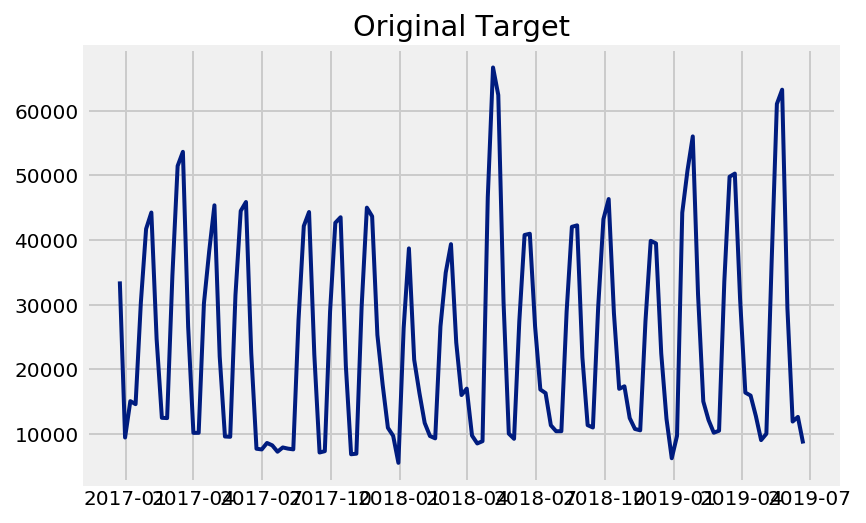

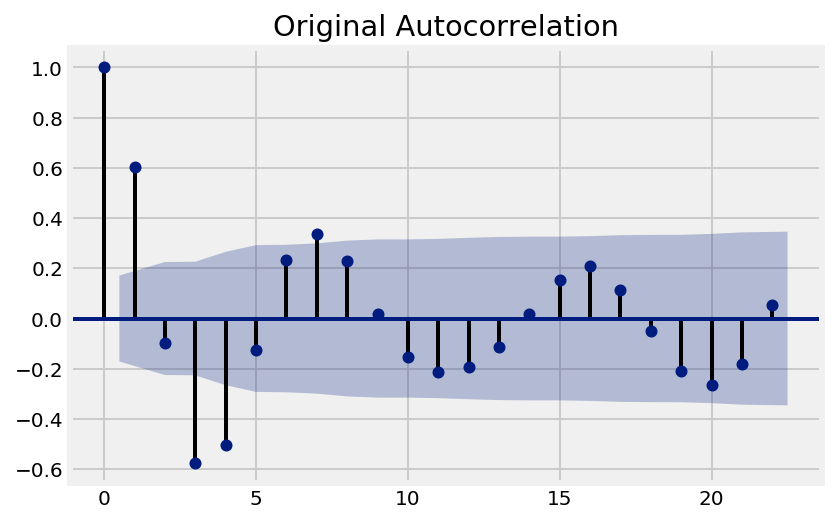

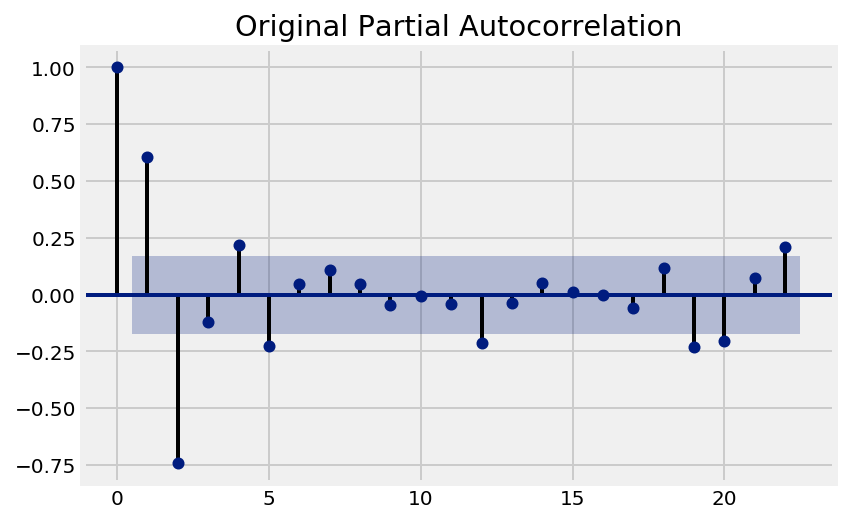

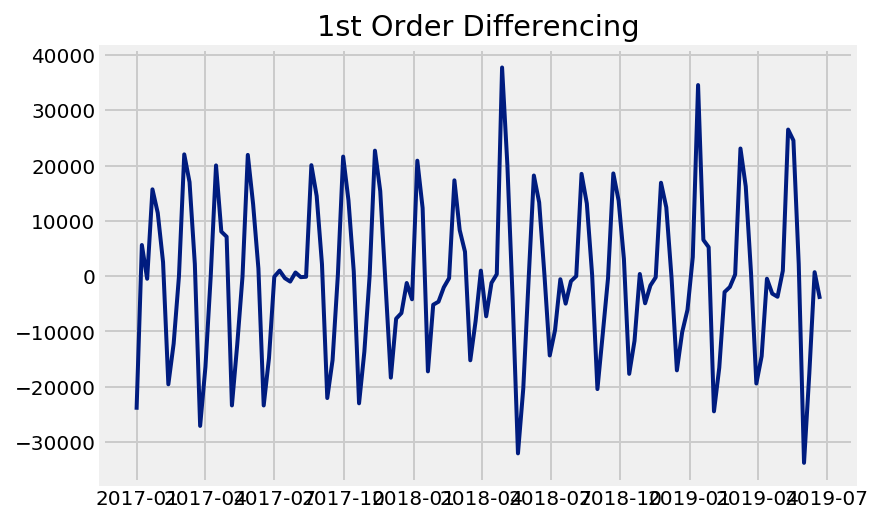

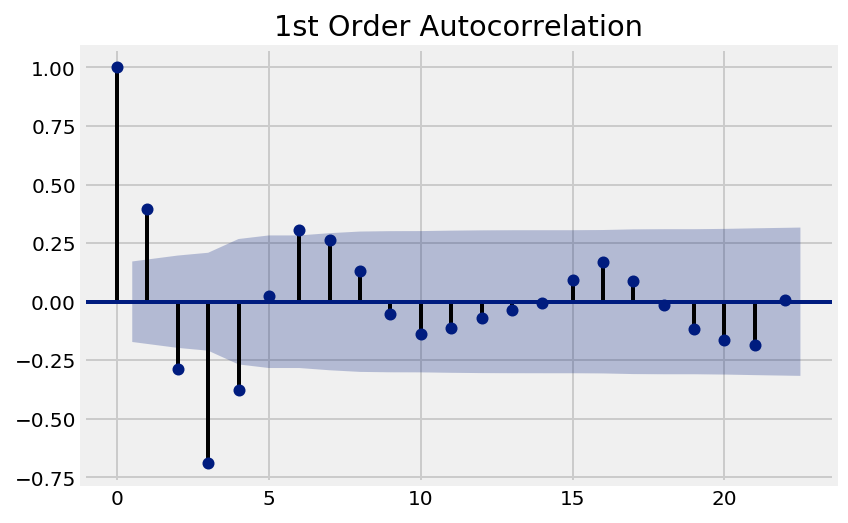

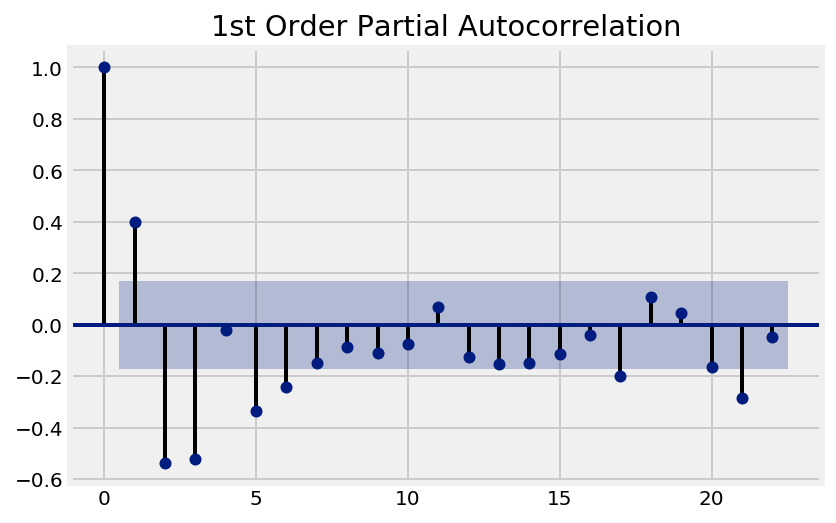

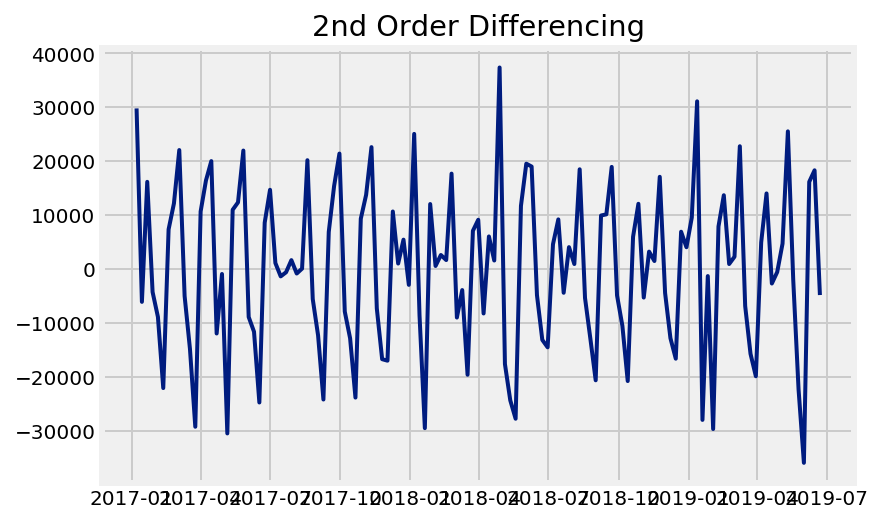

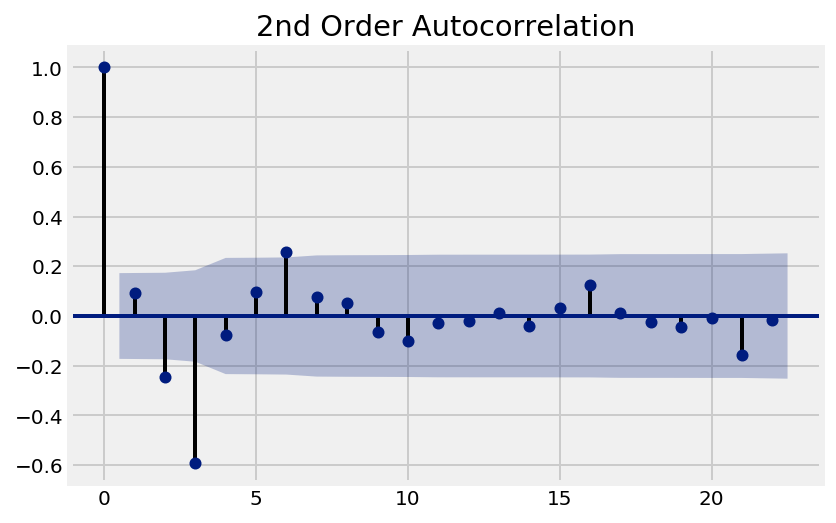

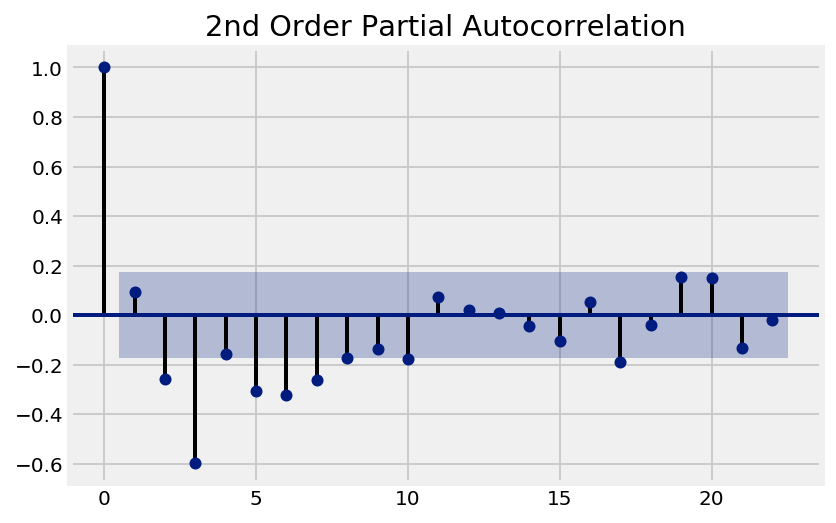

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

sku_id = sku_unique[12]

# Original Series
#fig, axes = plt.subplots(3, 2, sharex=True)

plt.plot(train_df.loc[train_df["sku"]==sku_id].target)
plt.title('Original Target')
plot_acf(train_df.loc[train_df["sku"]==sku_id].target)
plt.title('Original Autocorrelation')
plot_pacf(train_df.loc[train_df["sku"]==sku_id].target)
plt.title('Original Partial Autocorrelation')

plt.show()

# 1st Differencing
plt.plot(train_df.loc[train_df["sku"]==sku_id].target.diff())
plt.title('1st Order Differencing')
plot_acf(train_df.loc[train_df["sku"]==sku_id].target.diff().dropna())
plt.title('1st Order Autocorrelation')
plot_pacf(train_df.loc[train_df["sku"]==sku_id].target.diff().dropna())
plt.title('1st Order Partial Autocorrelation')

plt.show()

# 2nd Differencing
plt.plot(train_df.loc[train_df["sku"]==sku_id].target.diff().diff())
plt.title('2nd Order Differencing')
plot_acf(train_df.loc[train_df["sku"]==sku_id].target.diff().diff().dropna())
plt.title('2nd Order Autocorrelation')
plot_pacf(train_df.loc[train_df["sku"]==sku_id].target.diff().diff().dropna())
plt.title('2nd Order Partial Autocorrelation')

plt.show()



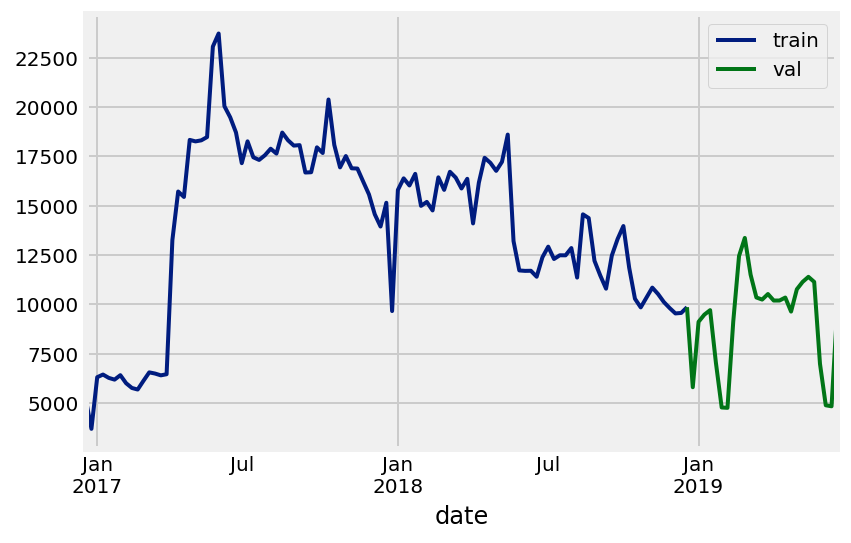

In [95]:
# SPLITTO SERIE IN TRAIN E VAL
sku_id = 2698
#sku_id = sku_unique[9]
train_df.loc[train_df["sku"]==sku_id].target[0:105].plot(label="train")
train_df.loc[train_df["sku"]==sku_id].target[104:].plot(label="val")
plt.legend()

df_sku_train = train_df.loc[train_df["sku"]==sku_id].target[0:101]
df_sku_val = train_df.loc[train_df["sku"]==sku_id].target[100:]

                             ARIMA Model Results                              
Dep. Variable:               D.target   No. Observations:                  100
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -880.635
Method:                       css-mle   S.D. of innovations           1583.602
Date:                Tue, 02 Jun 2020   AIC                           1775.269
Time:                        10:12:20   BIC                           1793.505
Sample:                    12-31-2016   HQIC                          1782.650
                         - 11-24-2018                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             45.5819    151.377      0.301      0.764    -251.111     342.275
ar.L1.D.target    -1.8915      0.102    -18.496      0.000      -2.092      -1.691
ar.L2.D.target    -1.1012      0.188

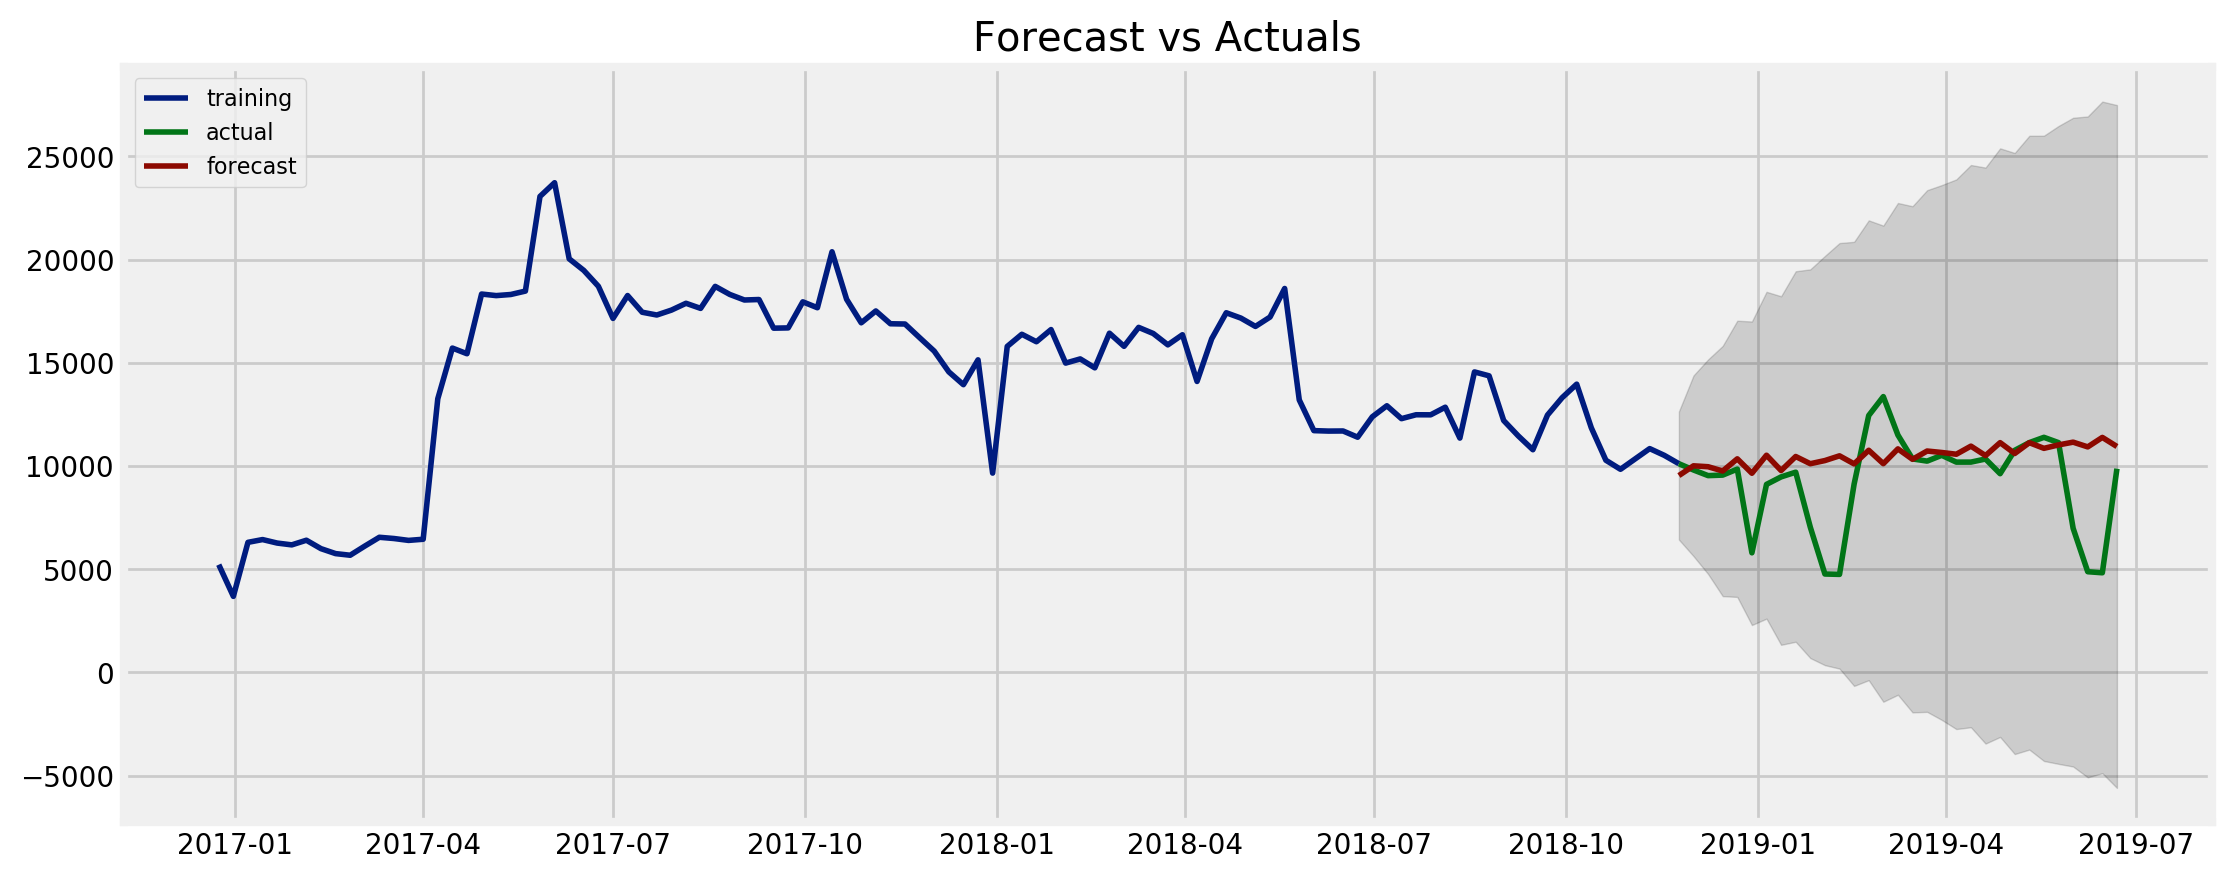

In [99]:
# Build Model
from statsmodels.tsa.arima_model import ARIMA
#model = ARIMA(df_sku_train, order=(1,1,1)) 
model = ARIMA(df_sku_train, order=(3,1,2))
#model = ARIMA(df_sku_train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(31, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=df_sku_val.index)
lower_series = pd.Series(conf[:, 0], index=df_sku_val.index)
upper_series = pd.Series(conf[:, 1], index=df_sku_val.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_sku_train, label='training')
plt.plot(df_sku_val, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

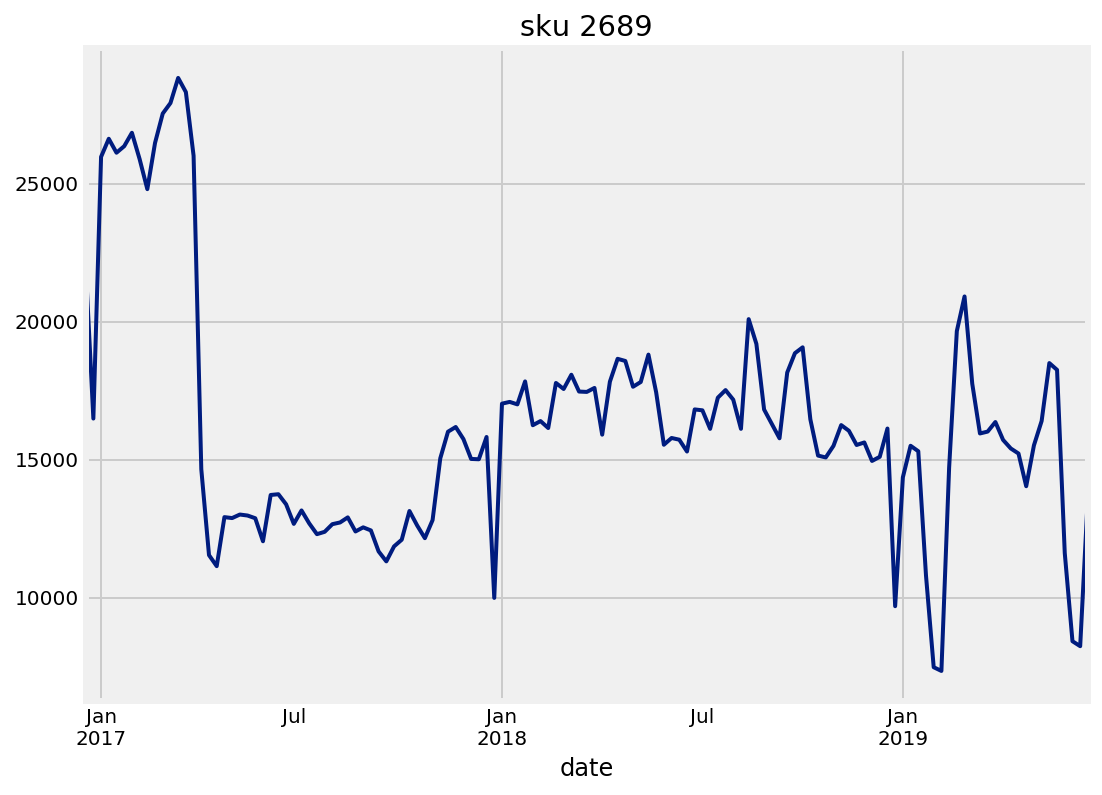

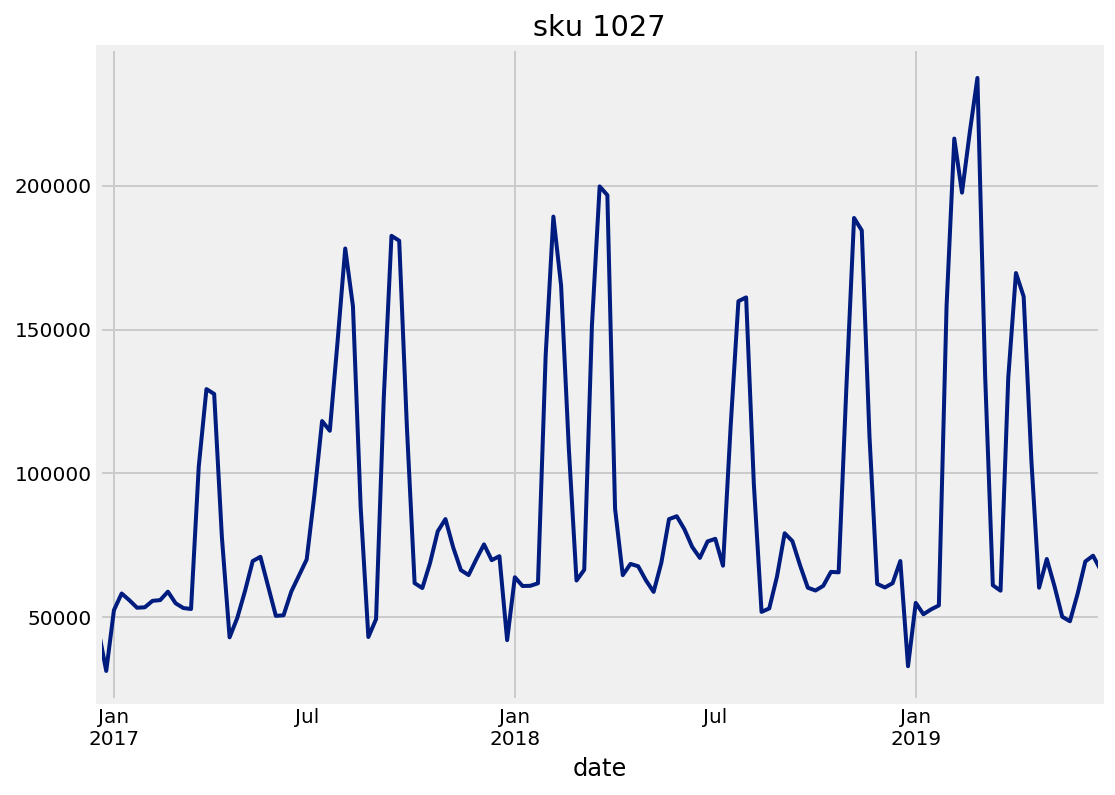

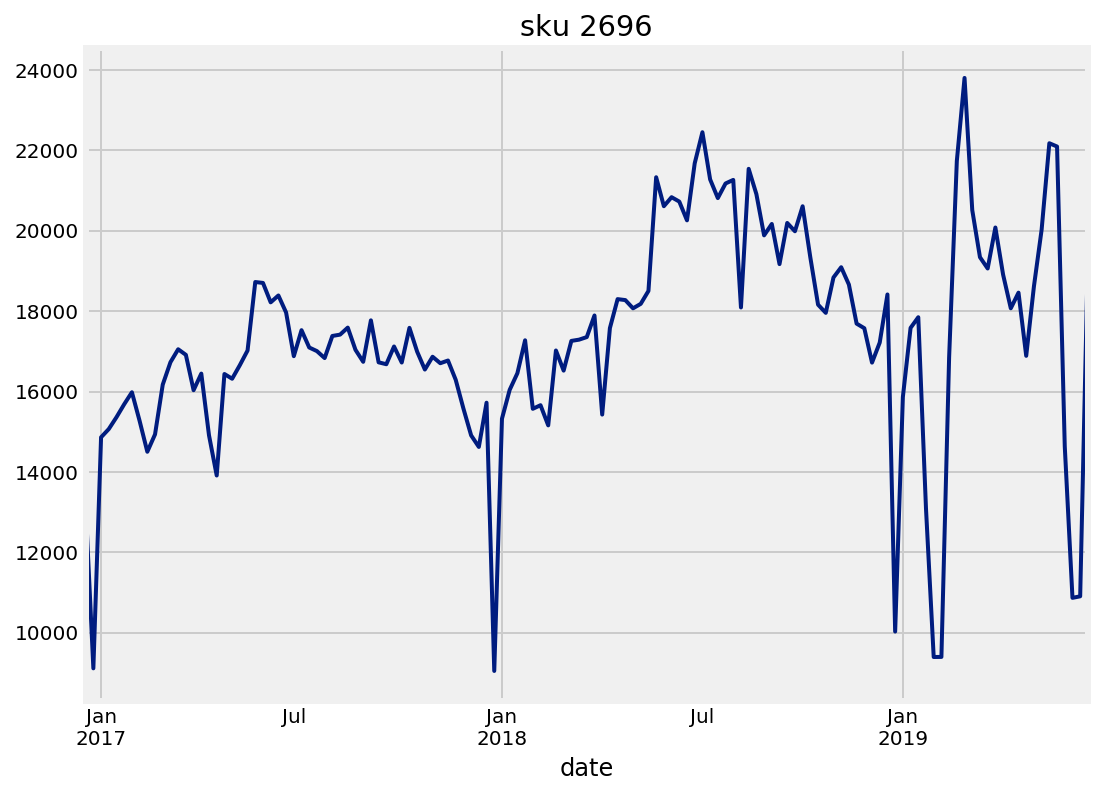

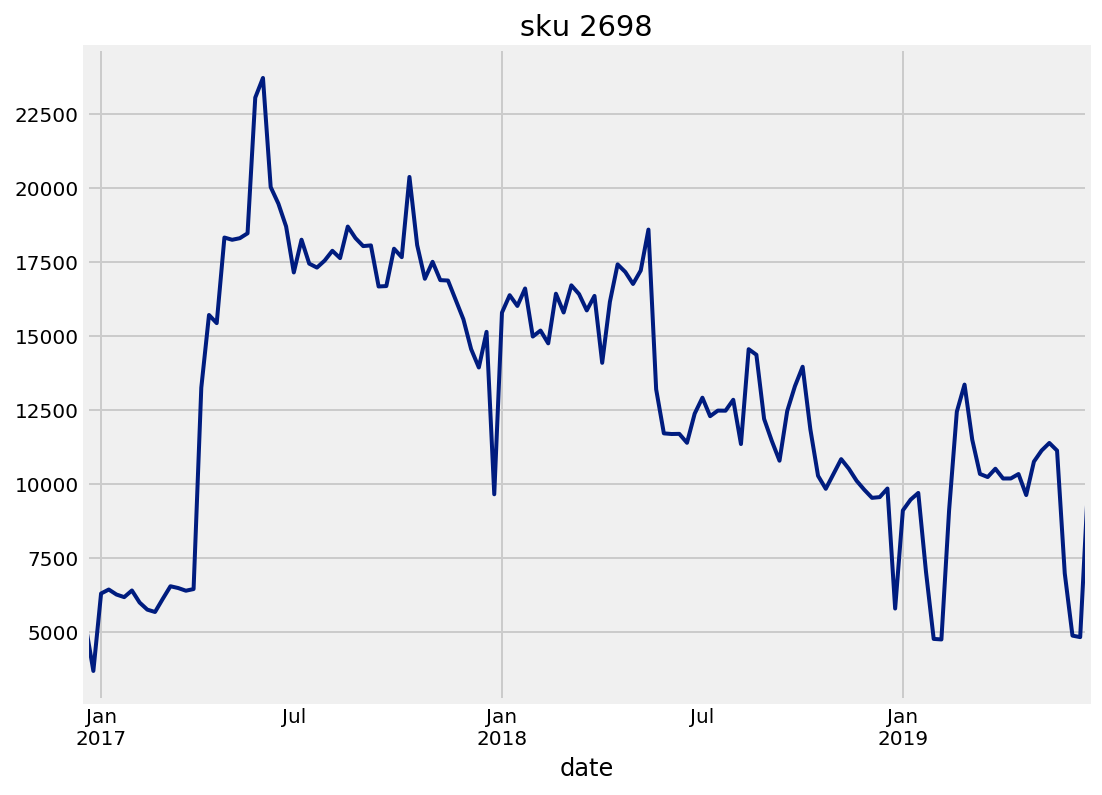

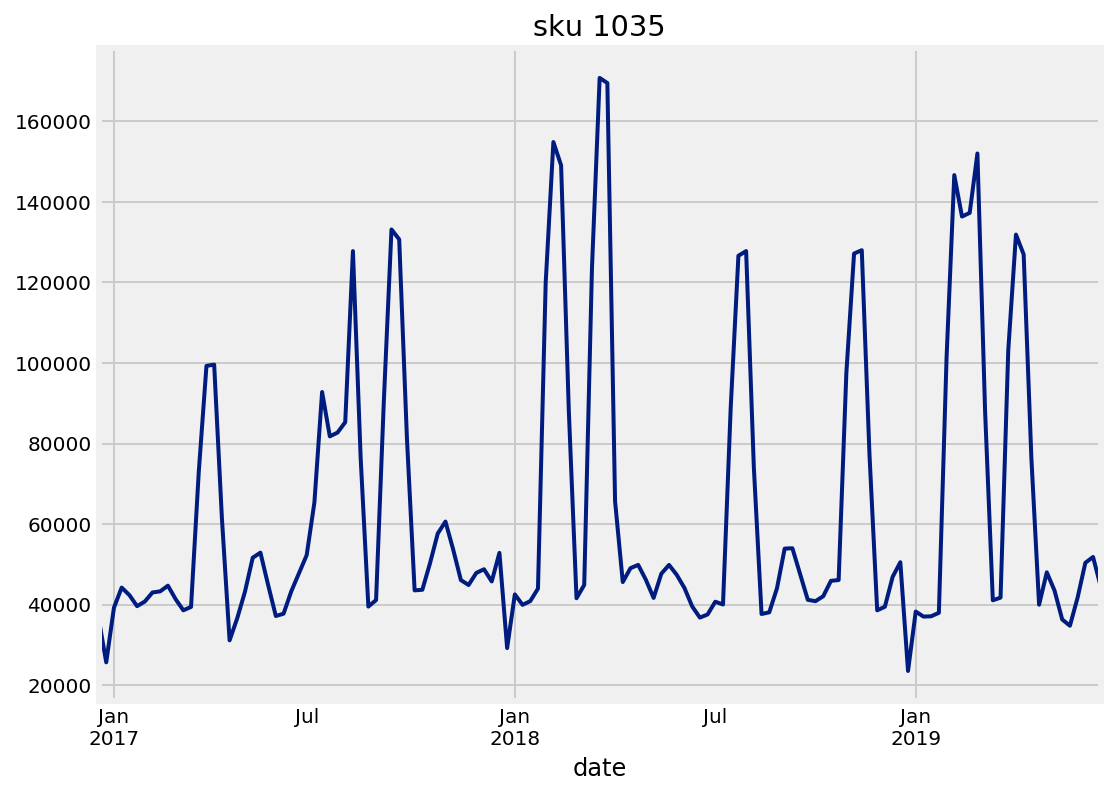

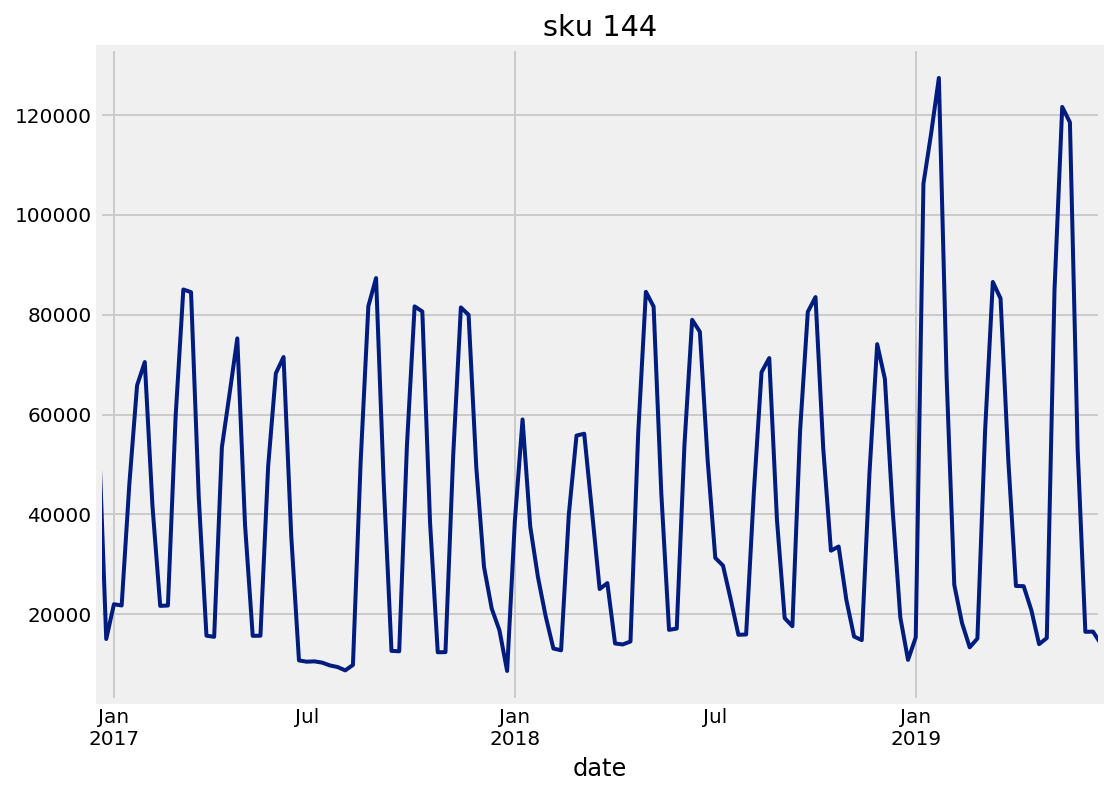

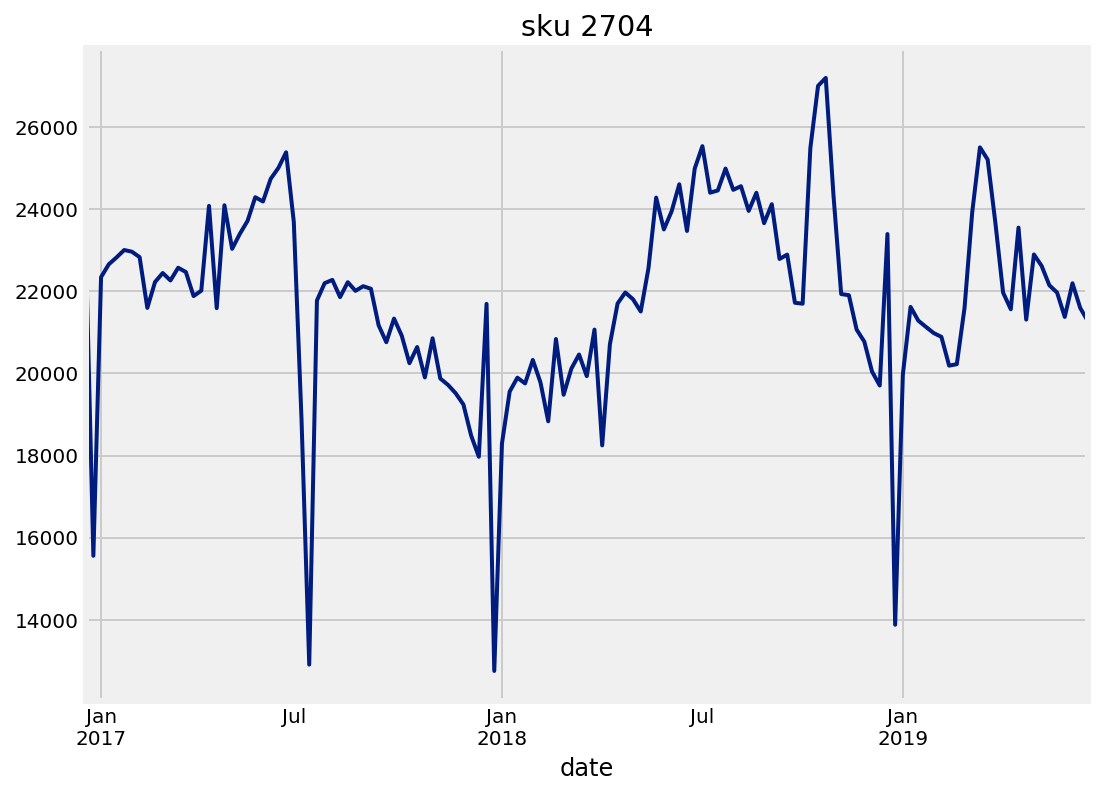

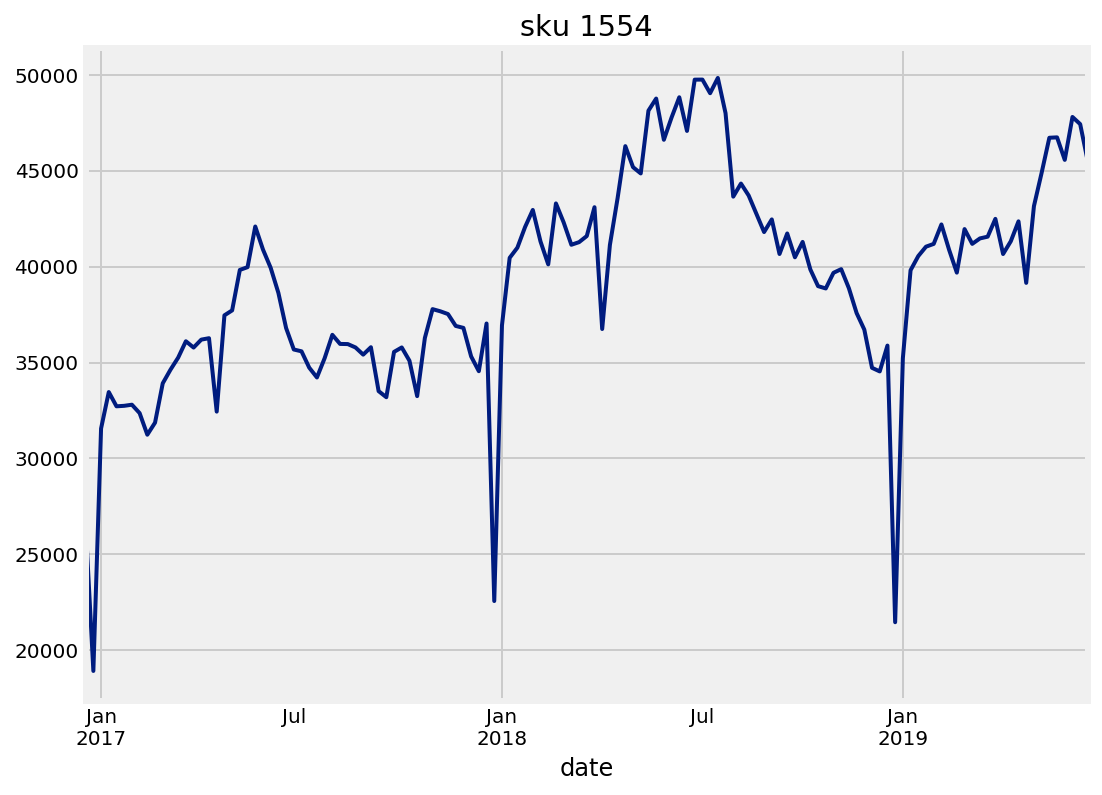

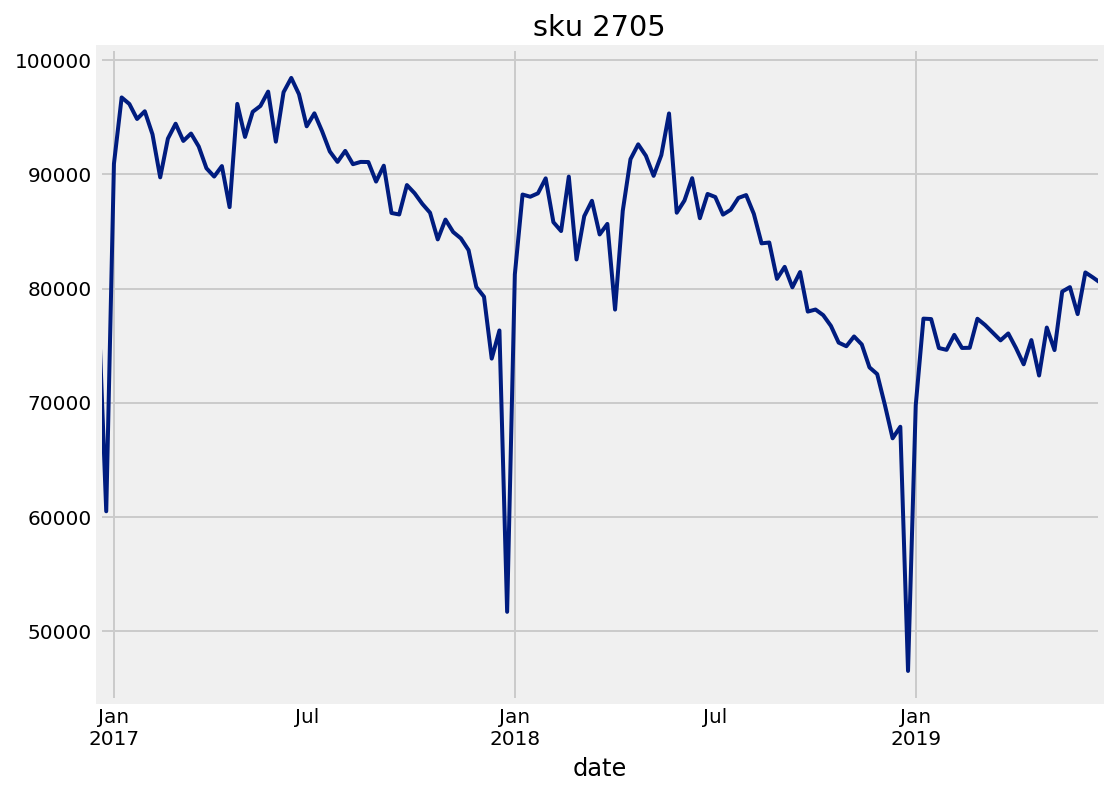

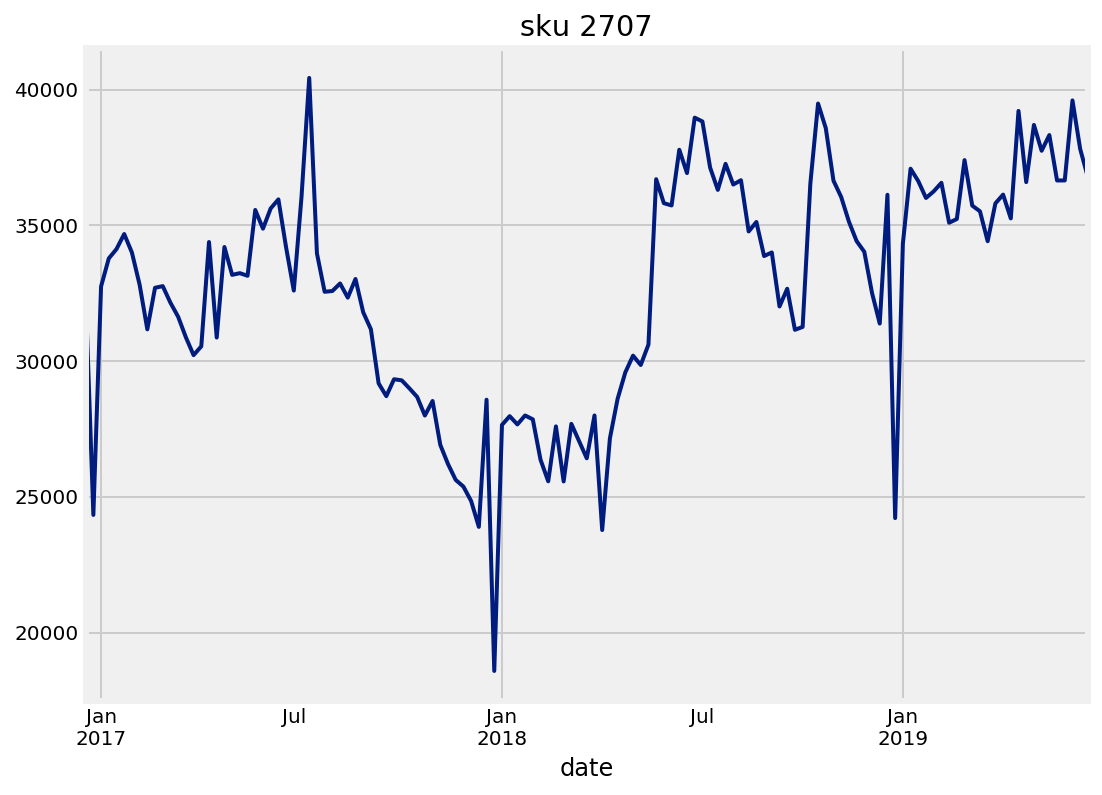

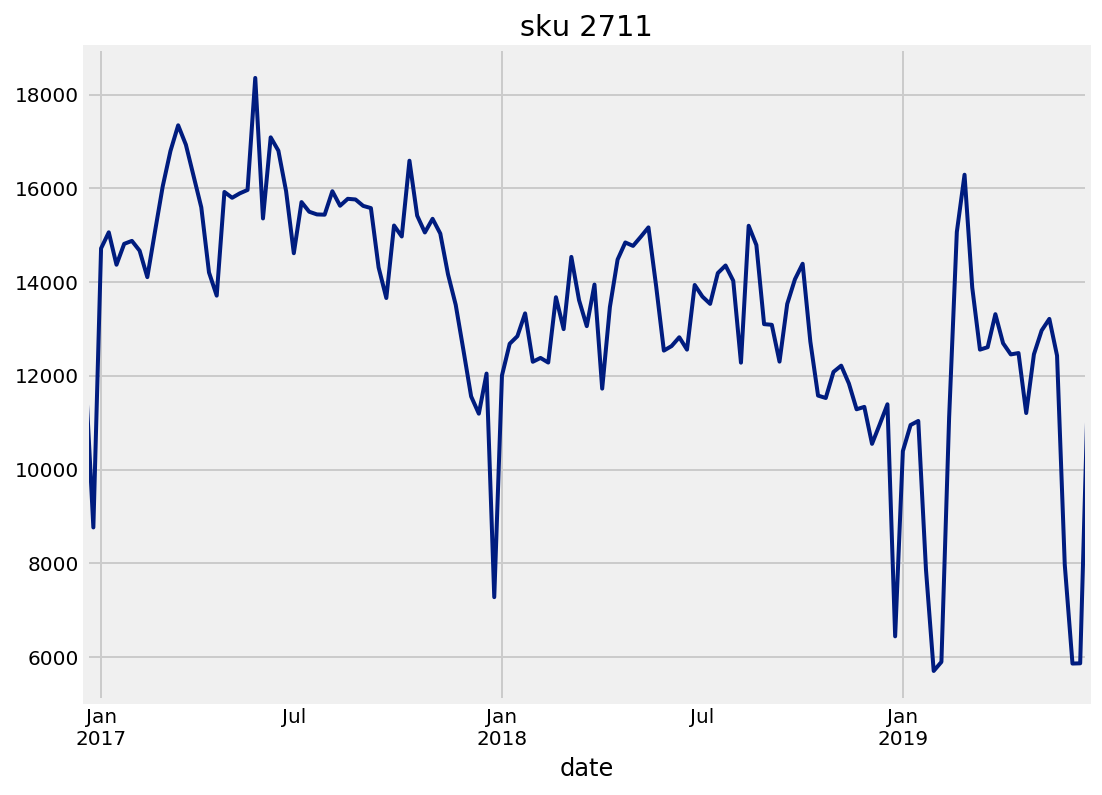

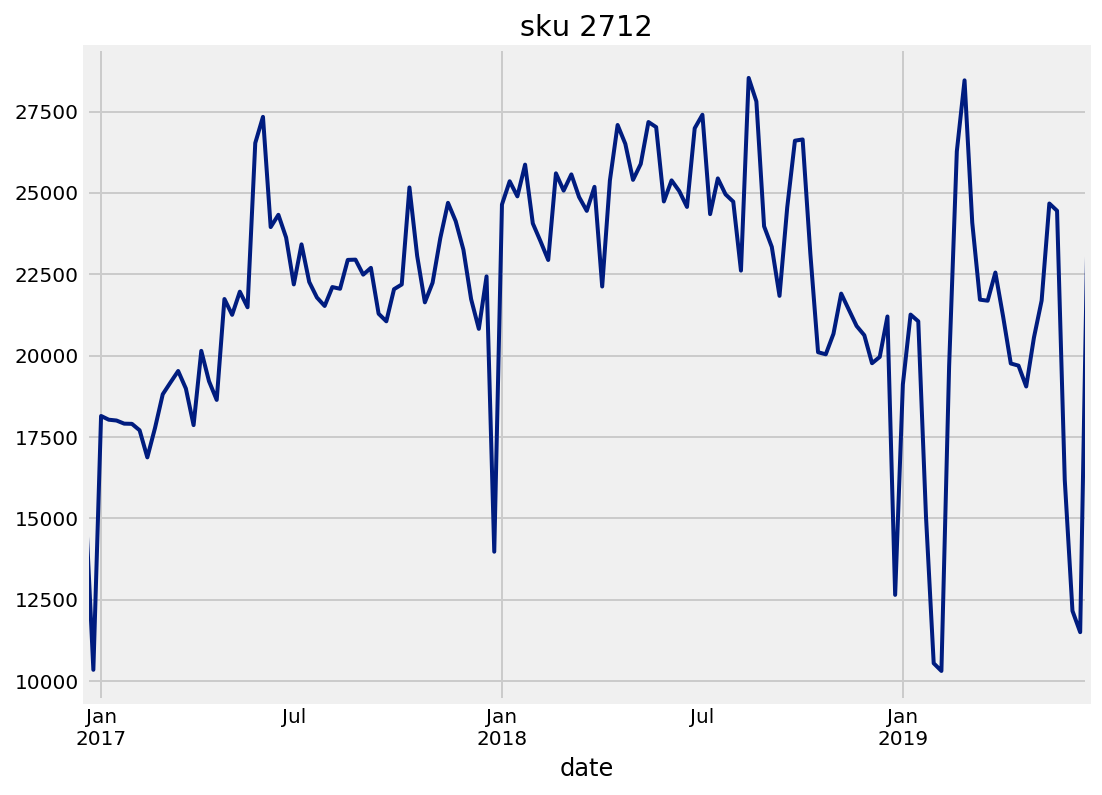

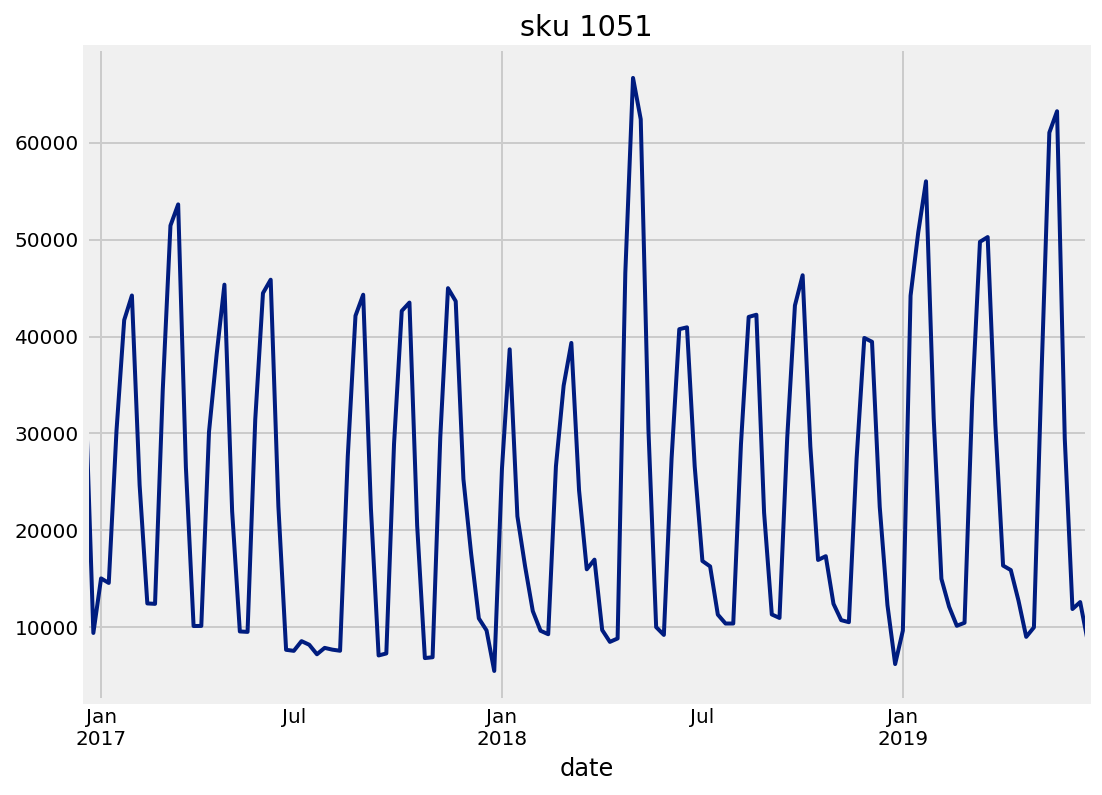

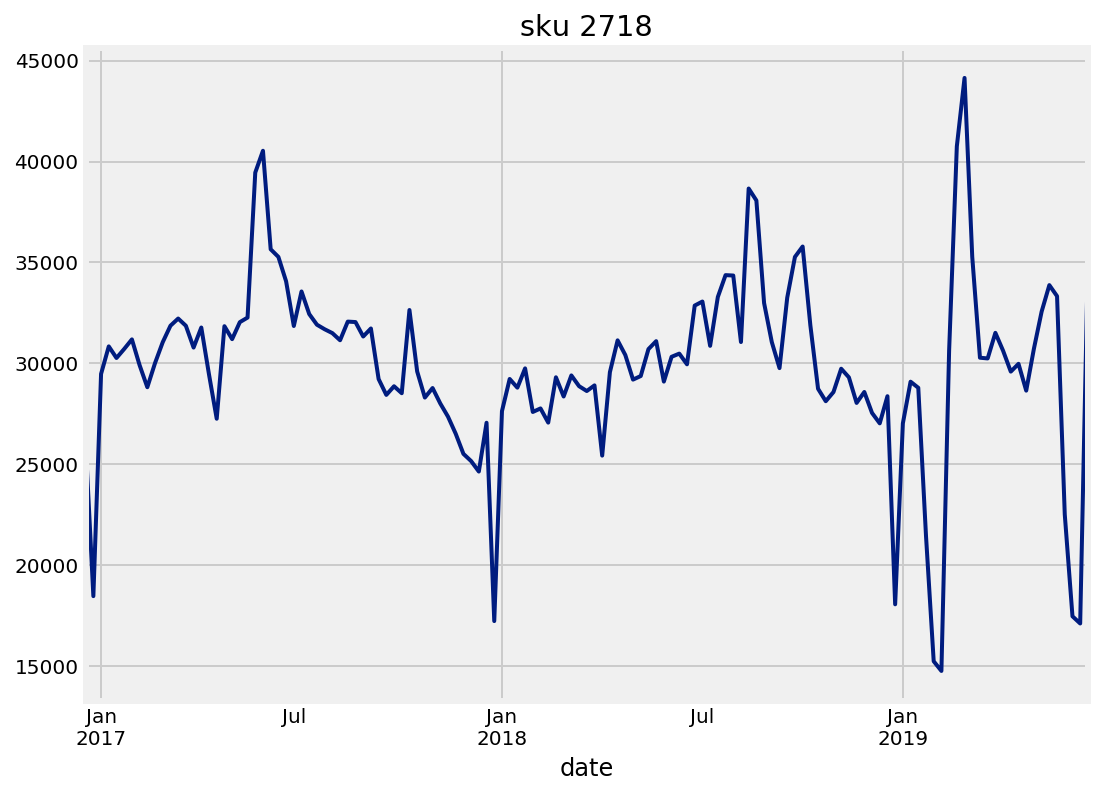

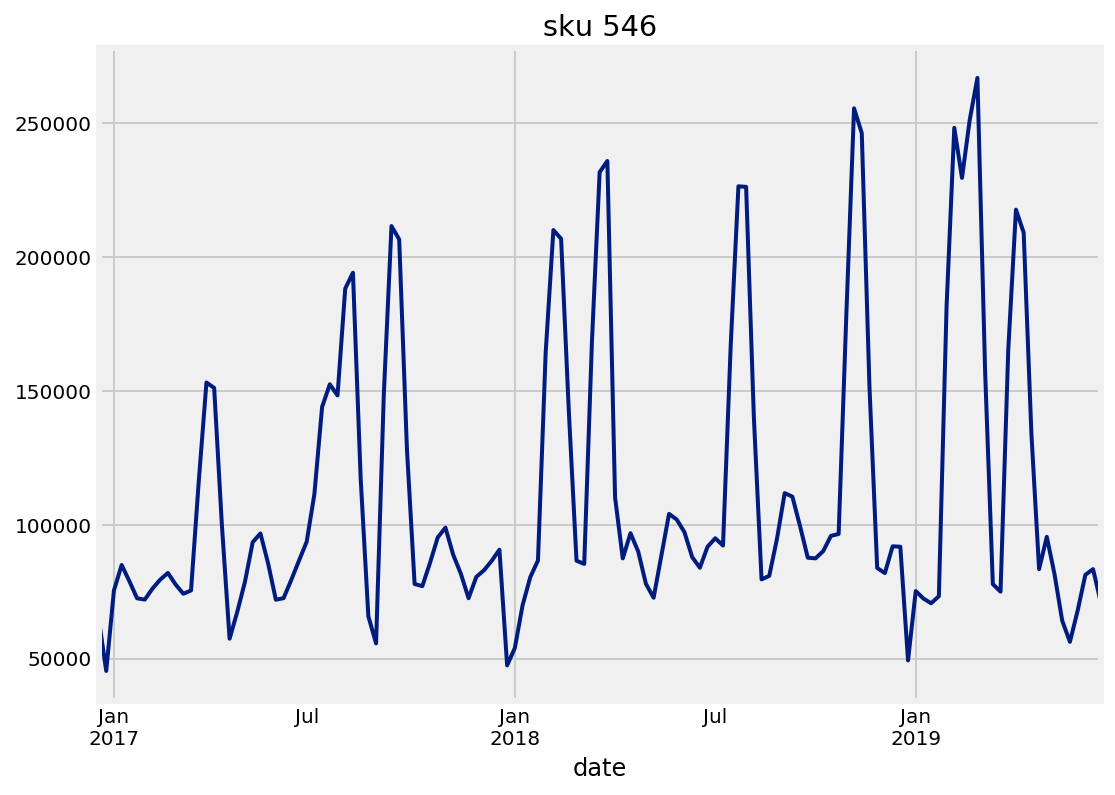

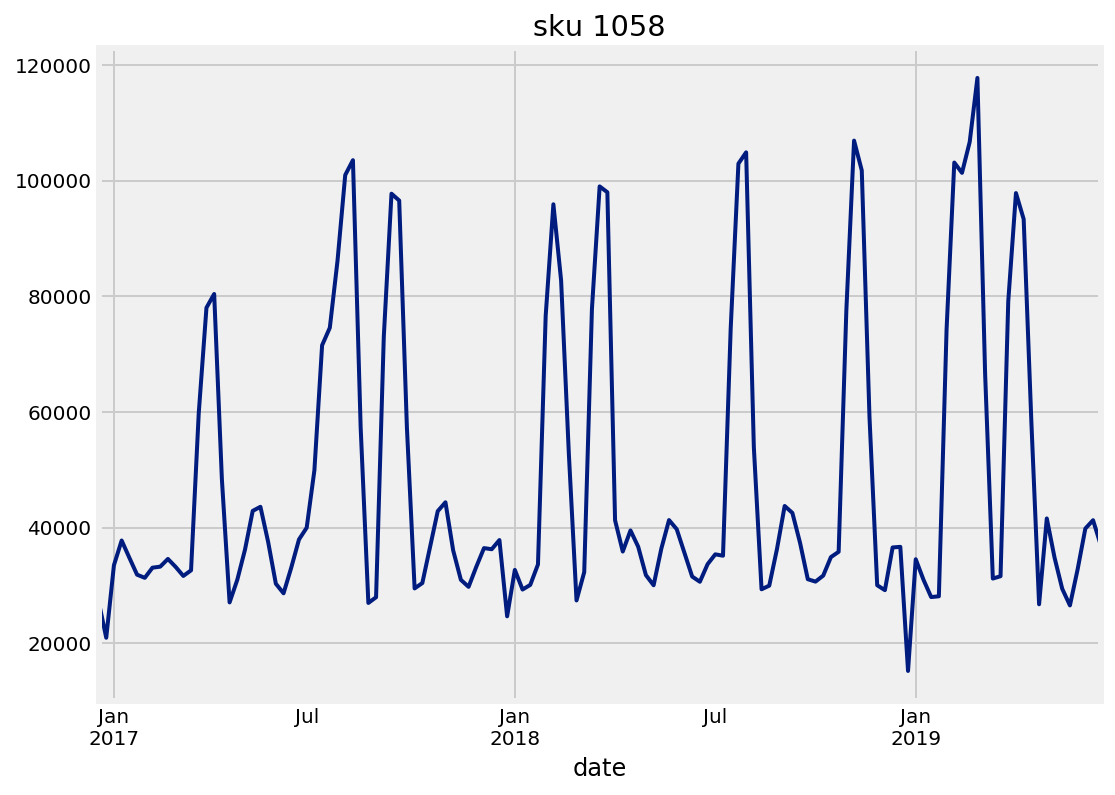

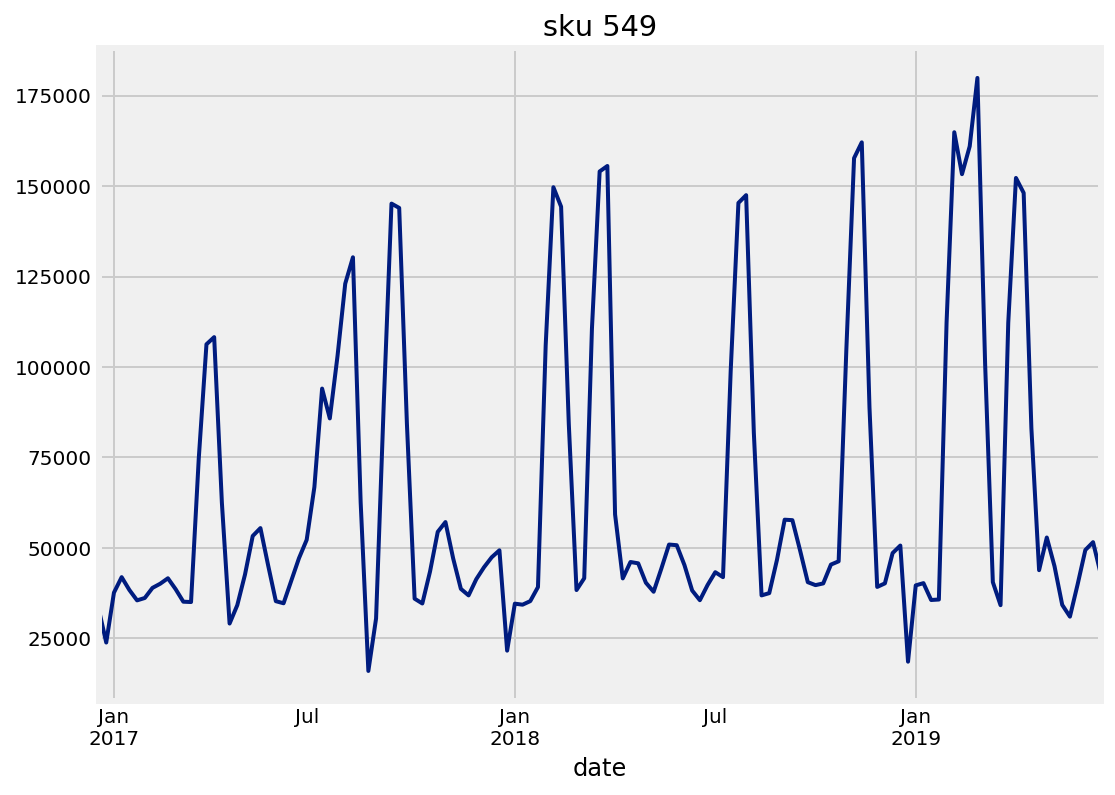

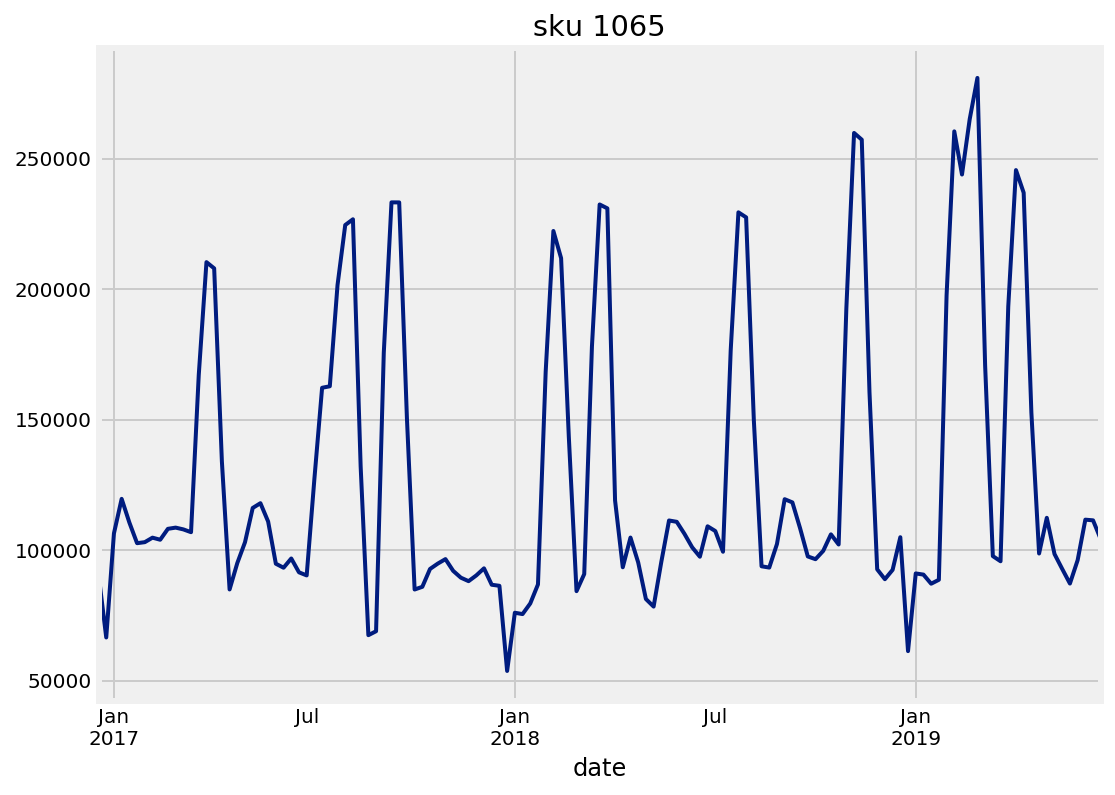

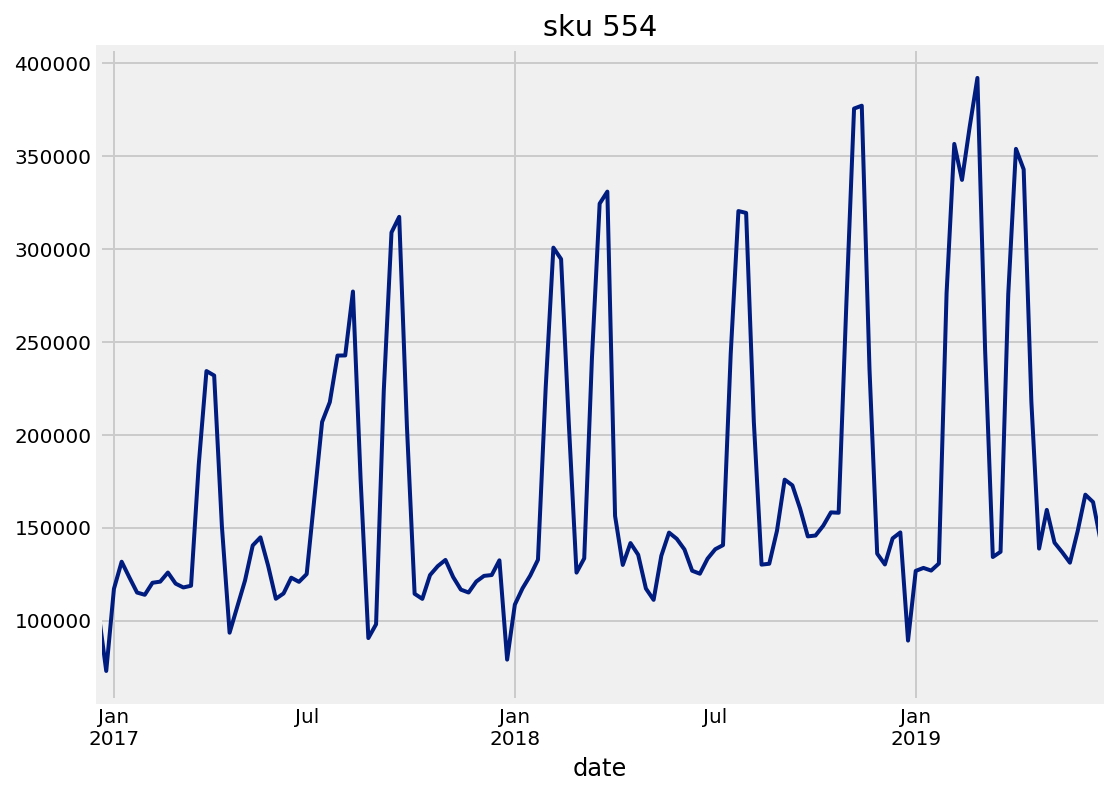

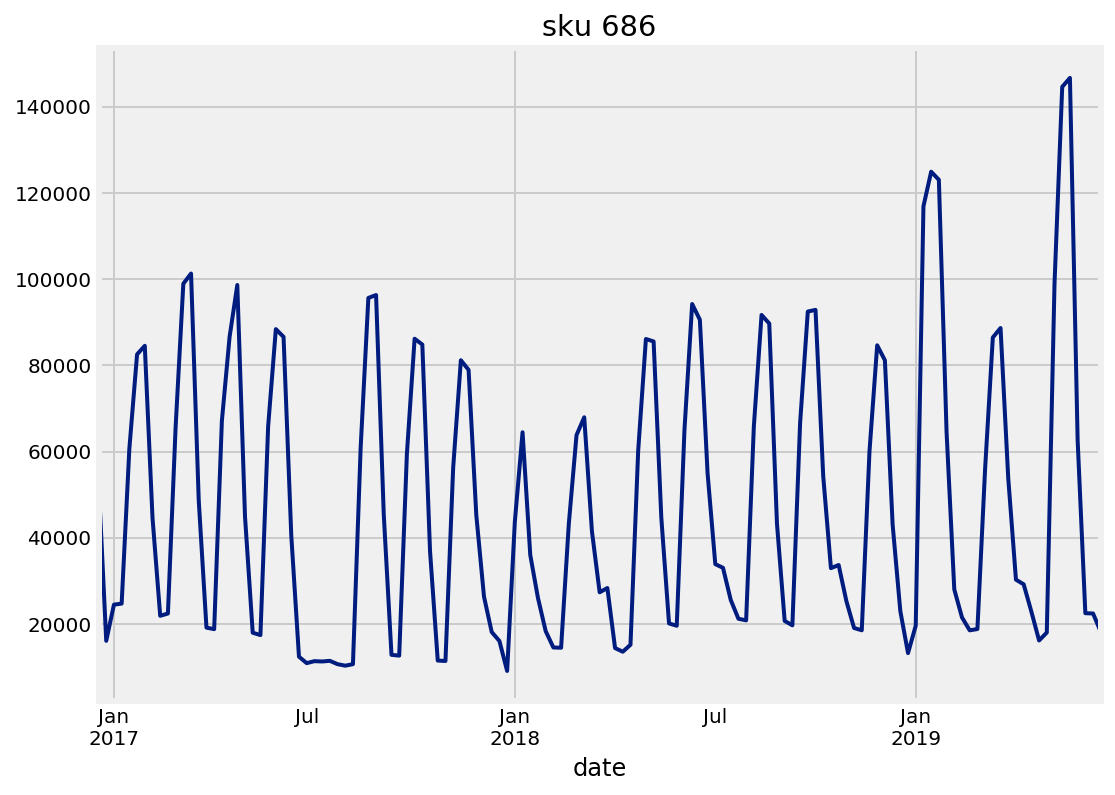

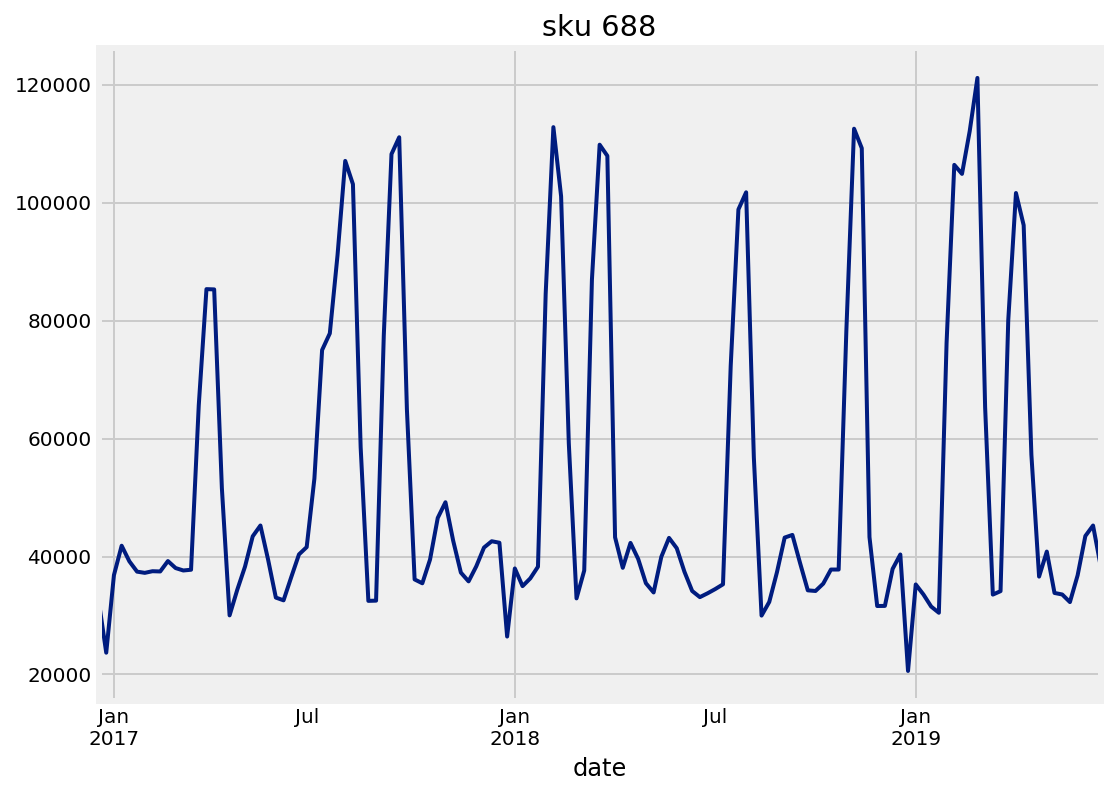

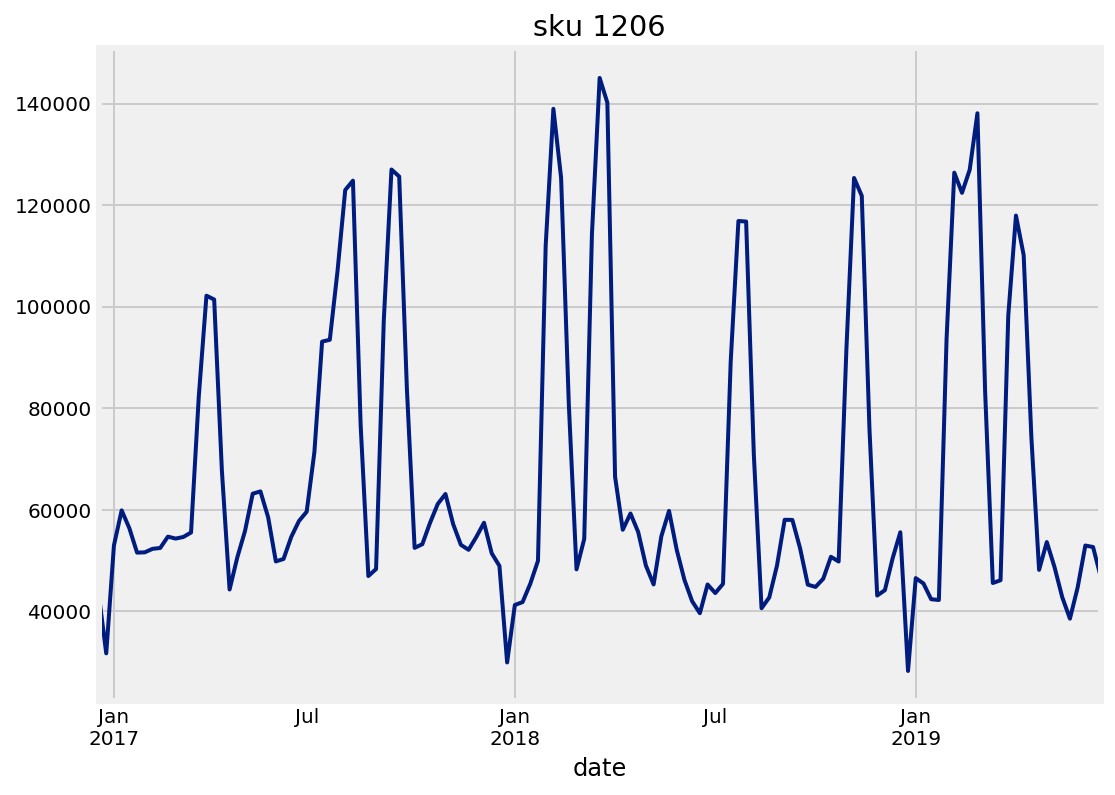

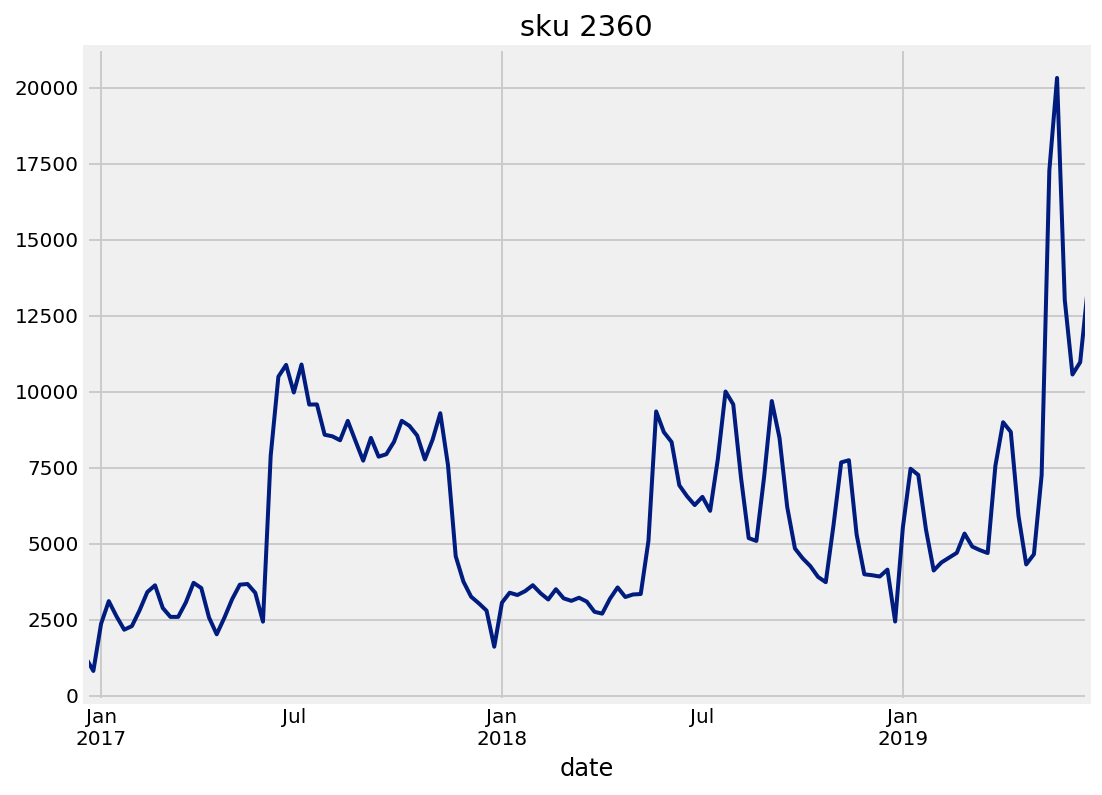

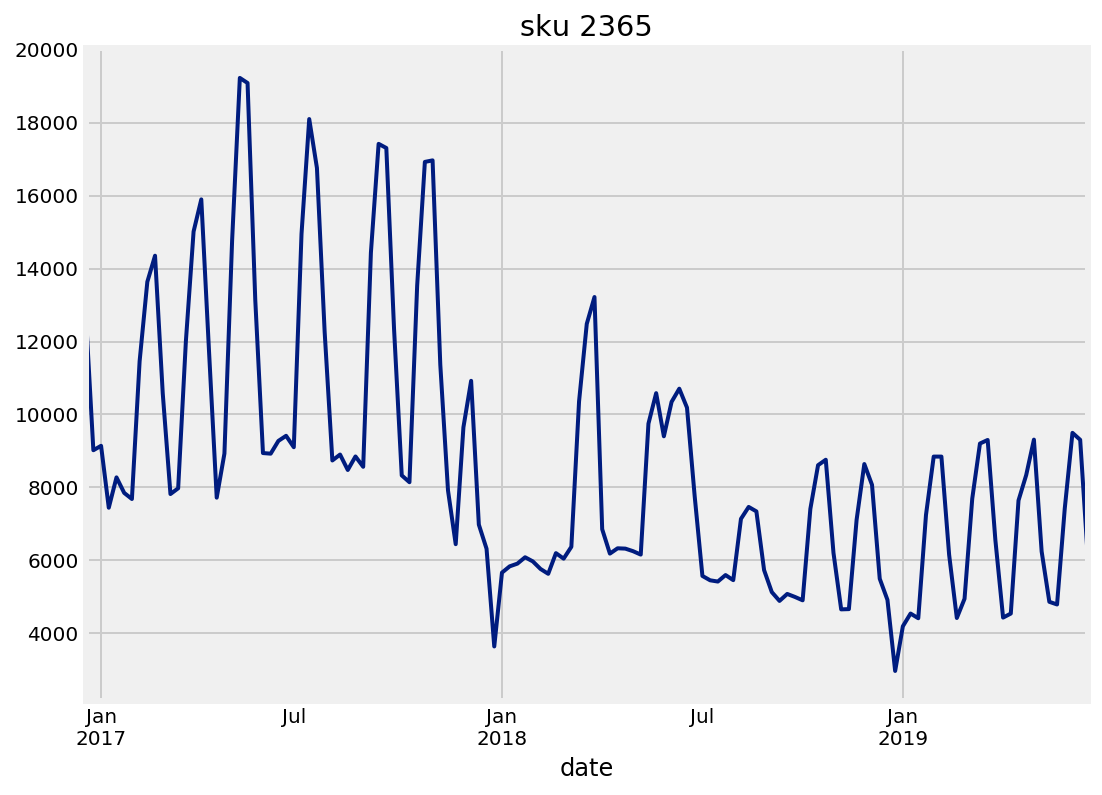

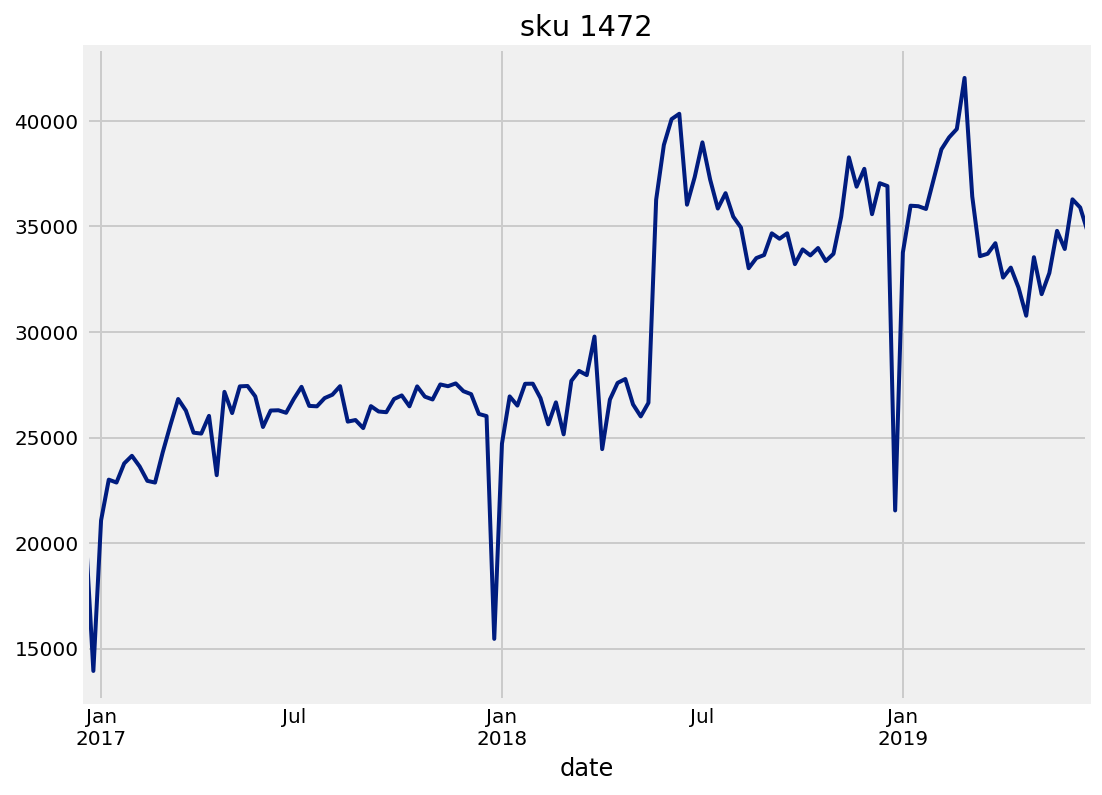

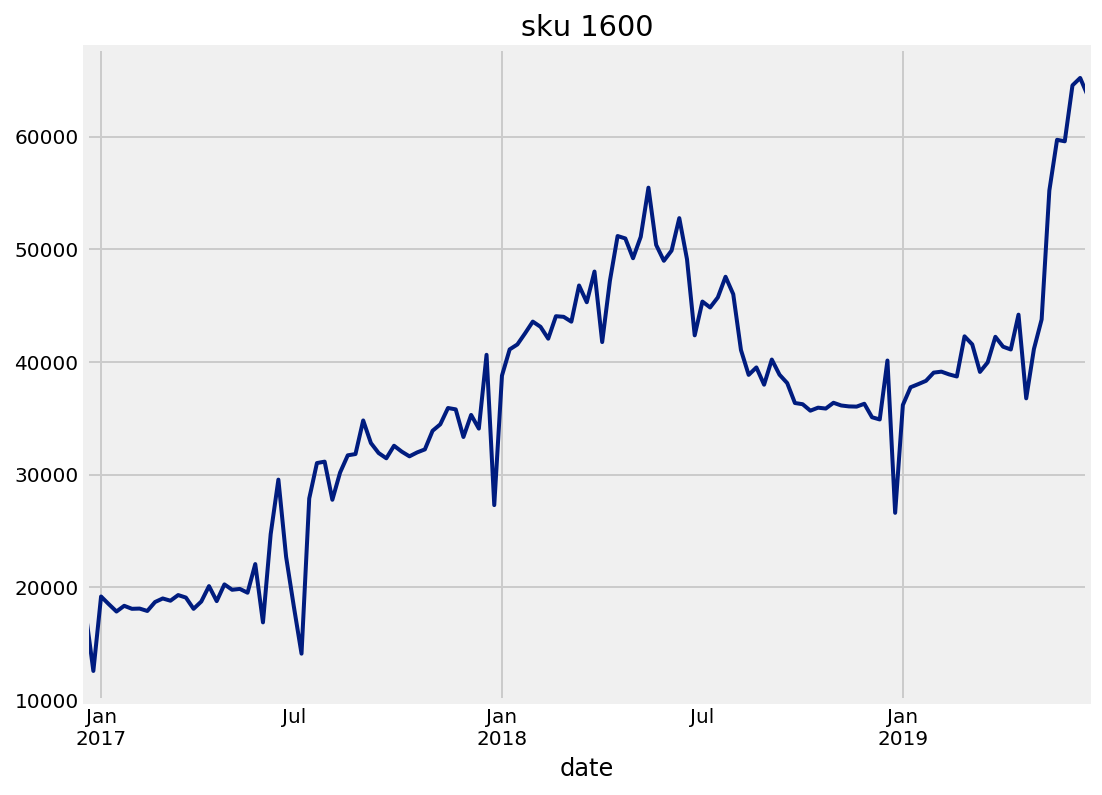

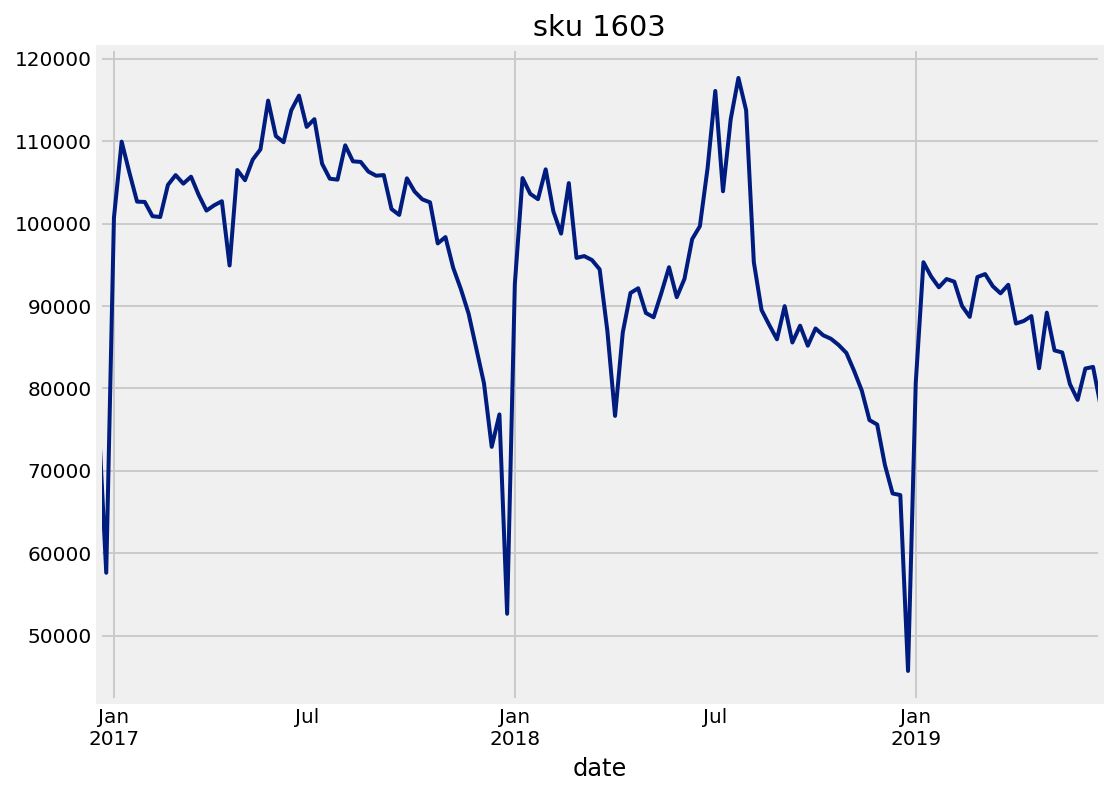

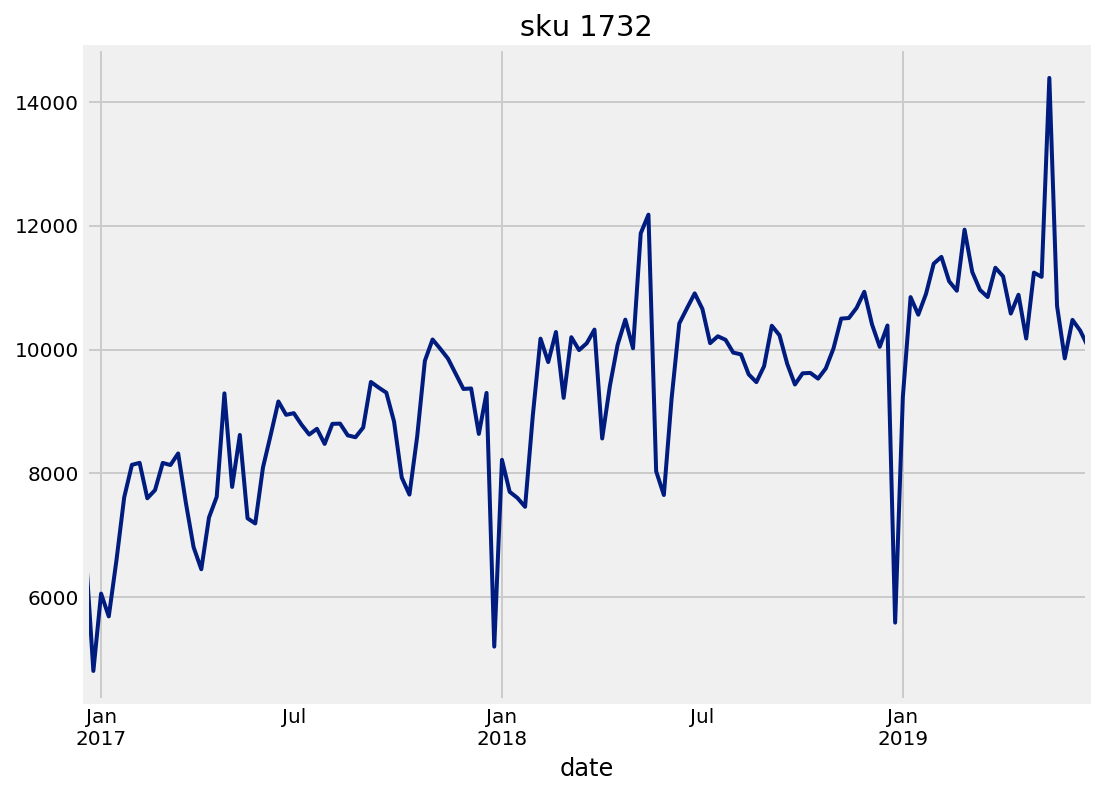

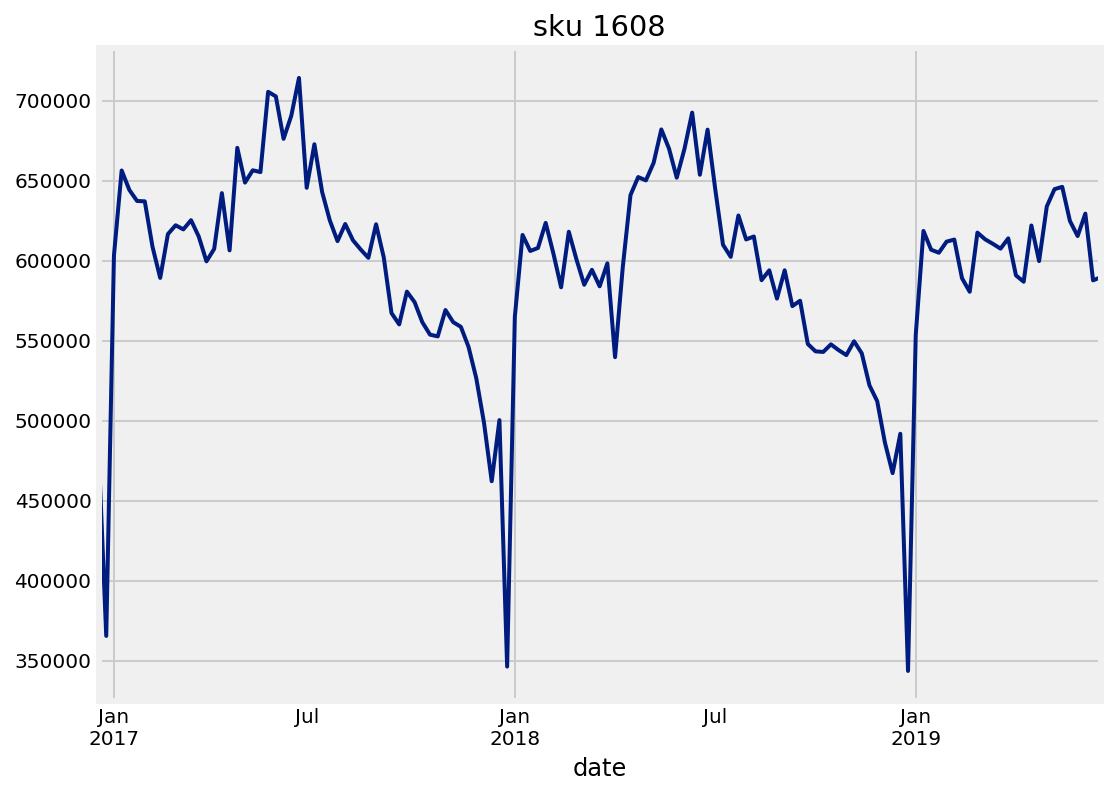

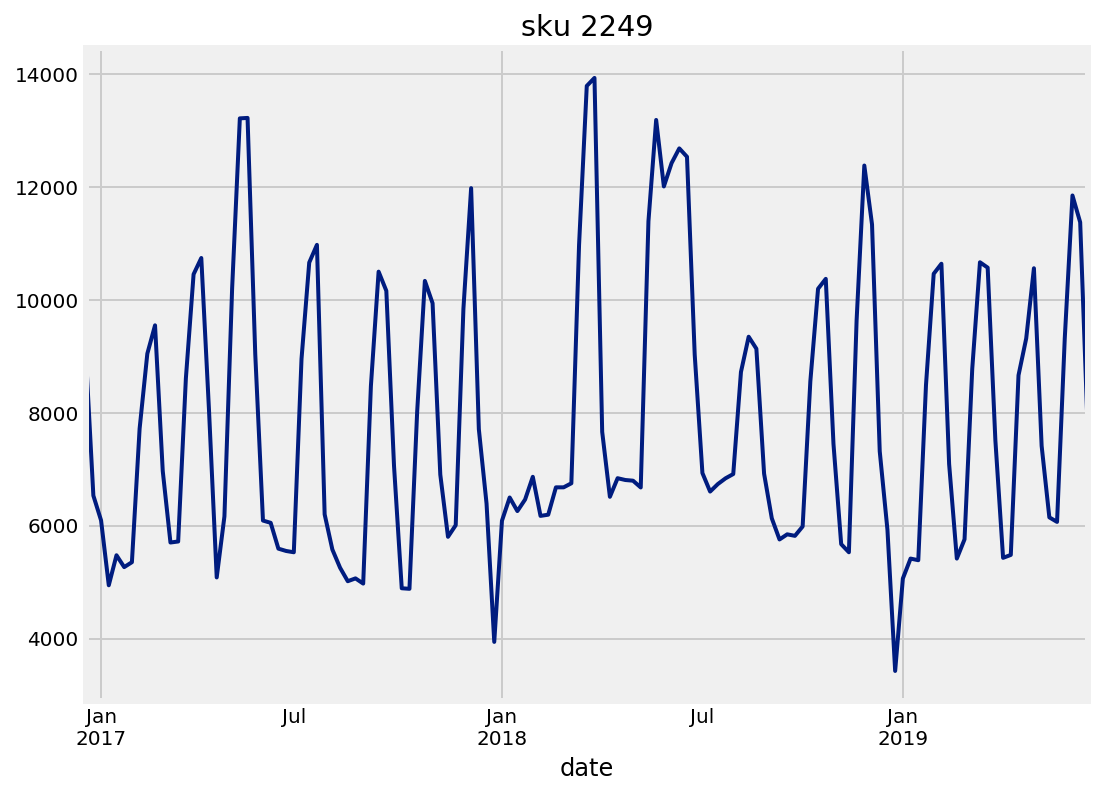

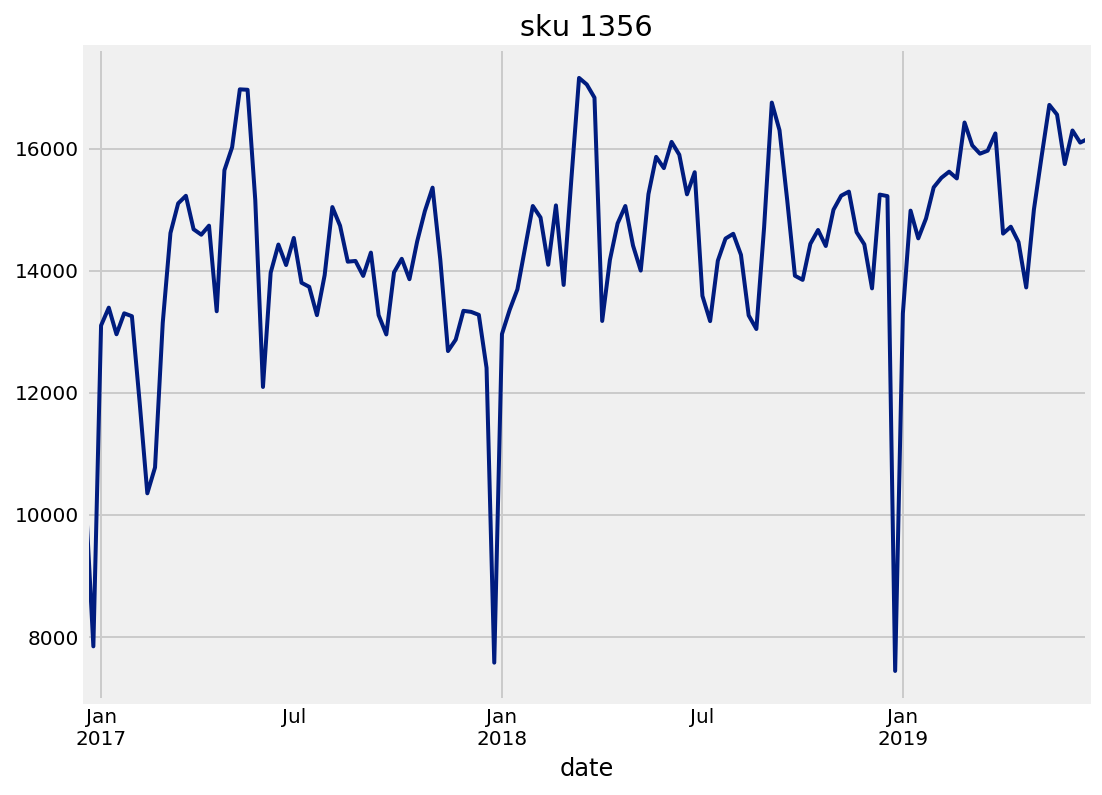

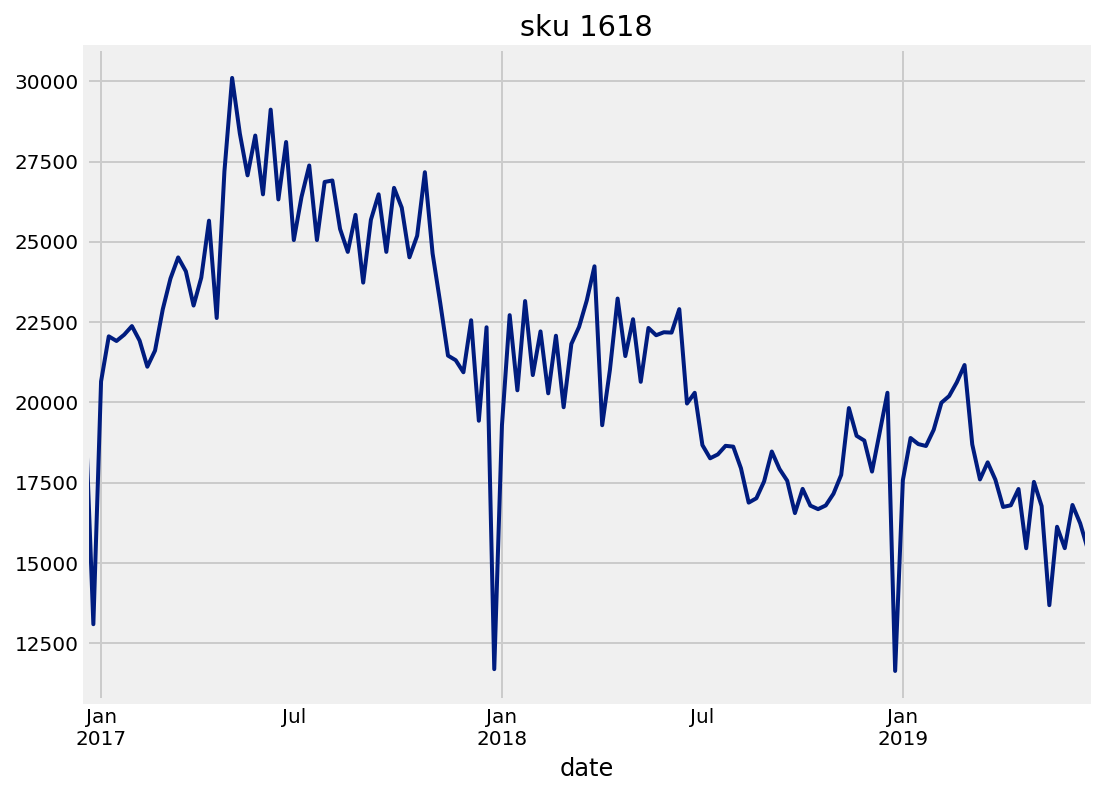

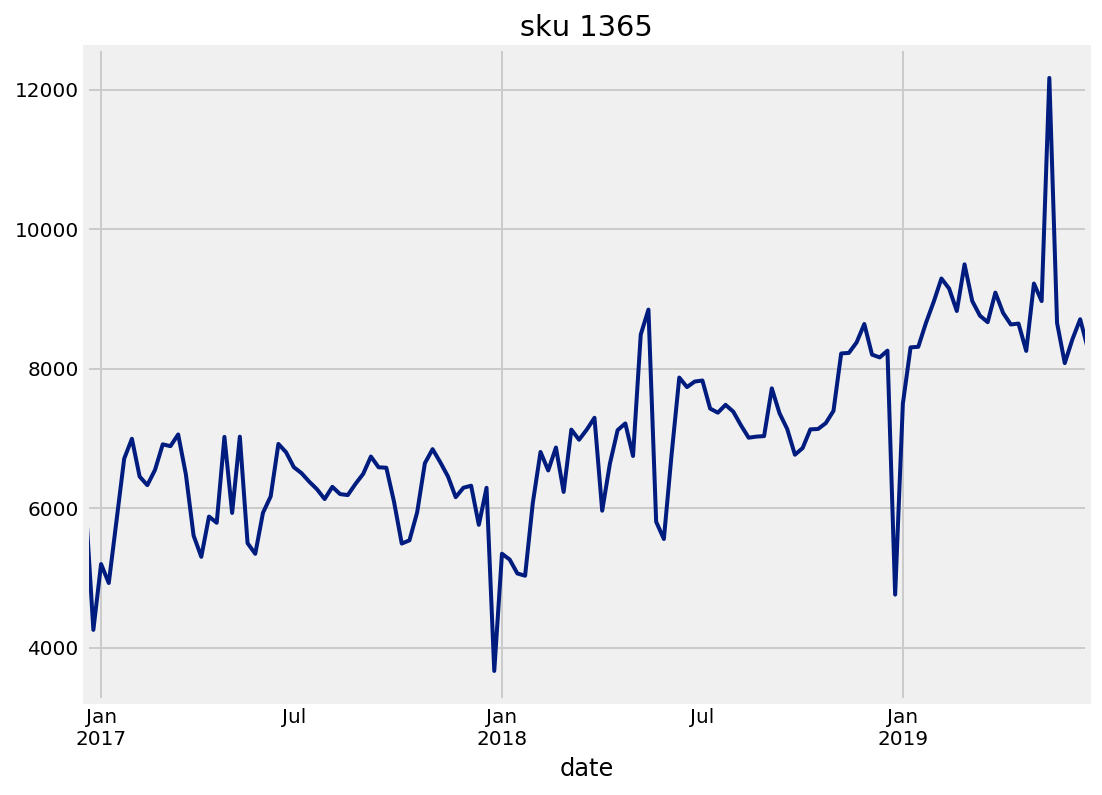

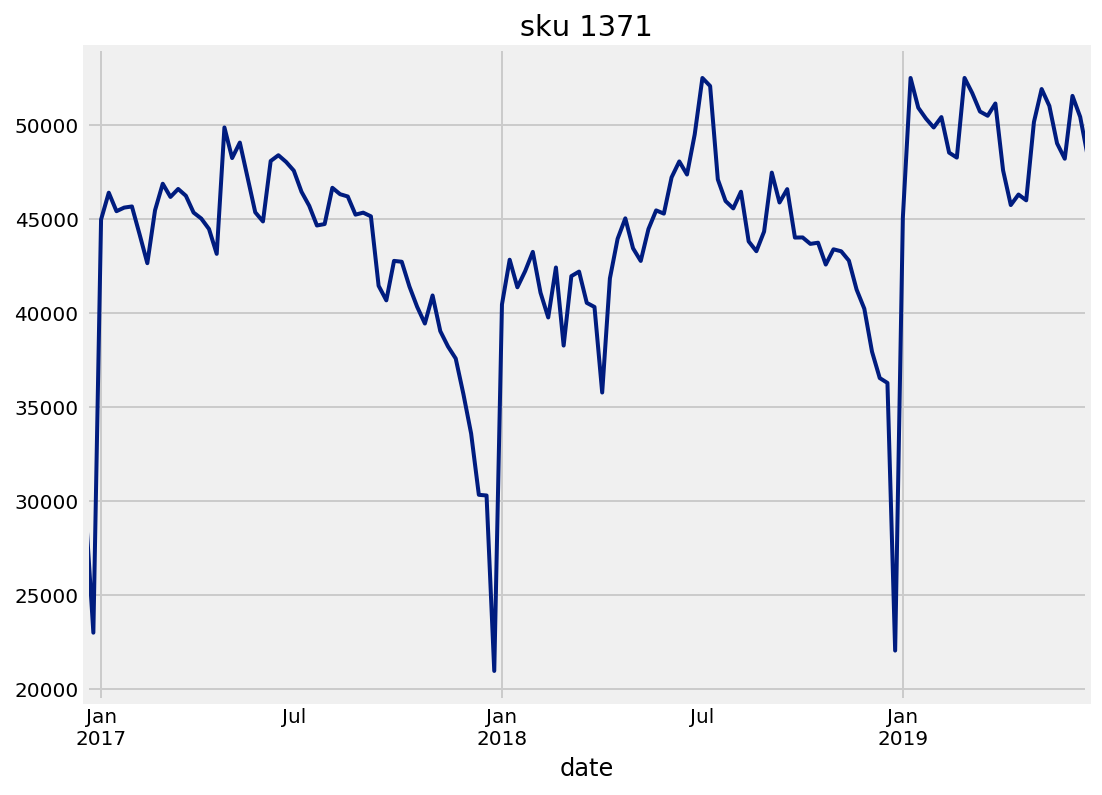

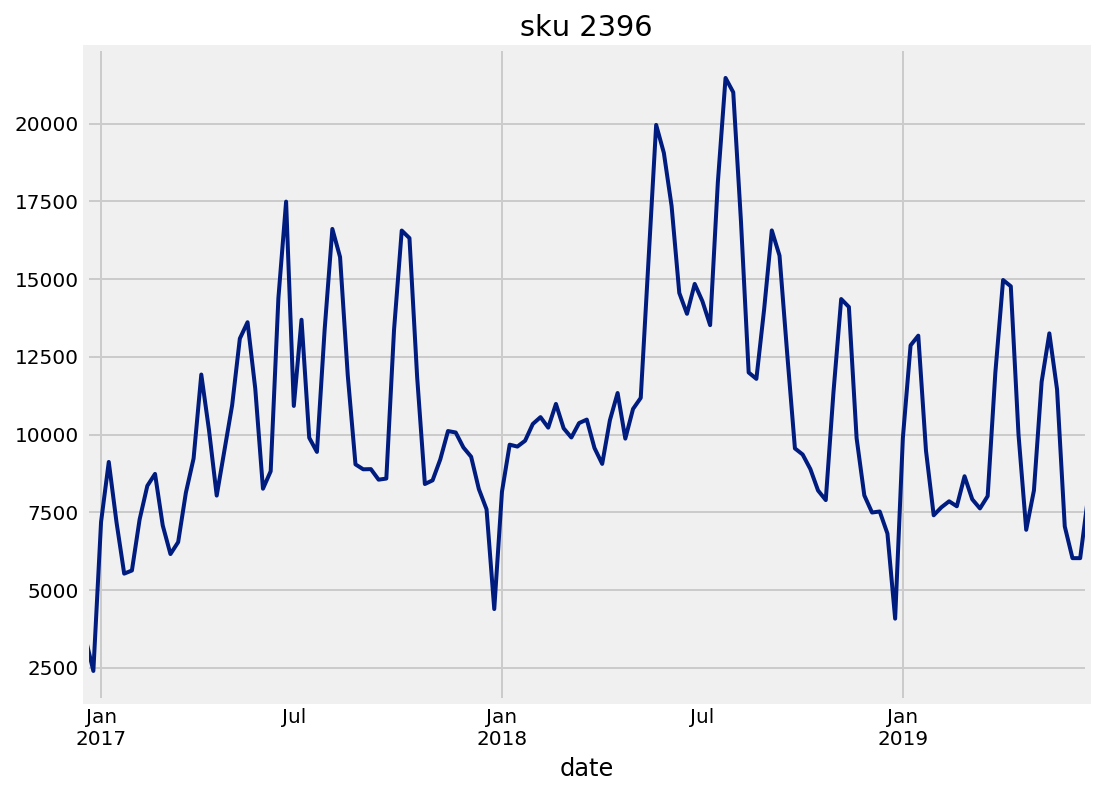

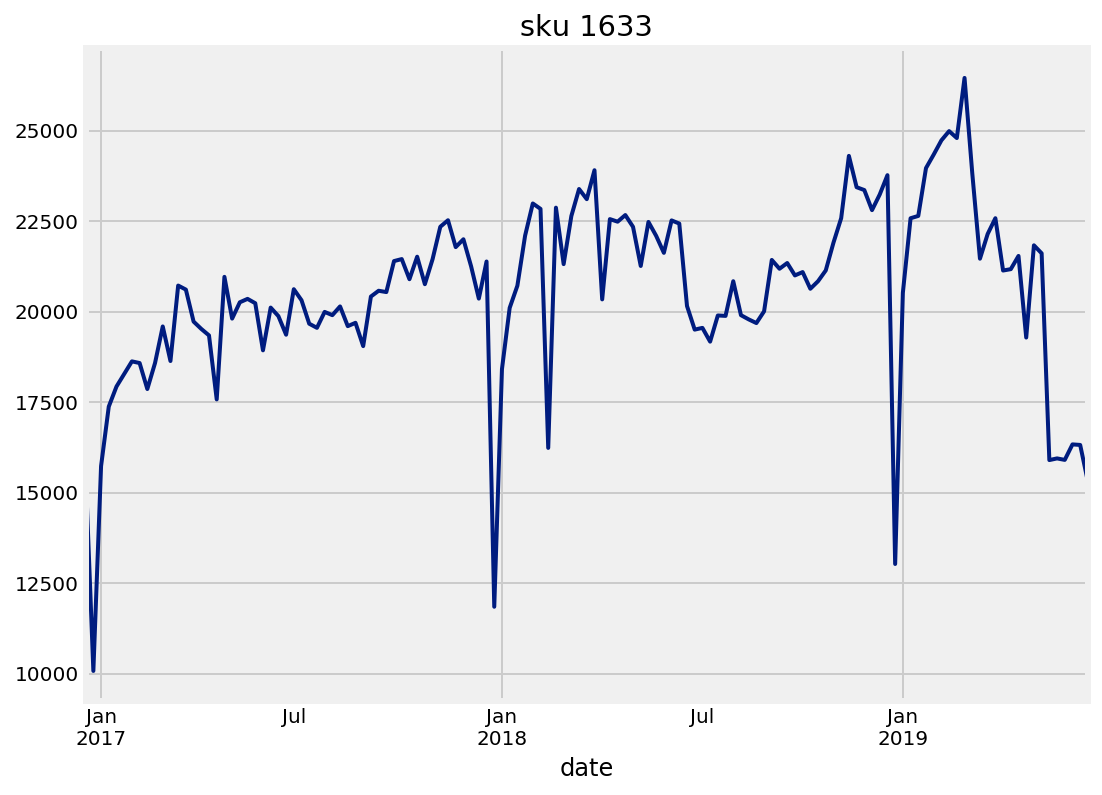

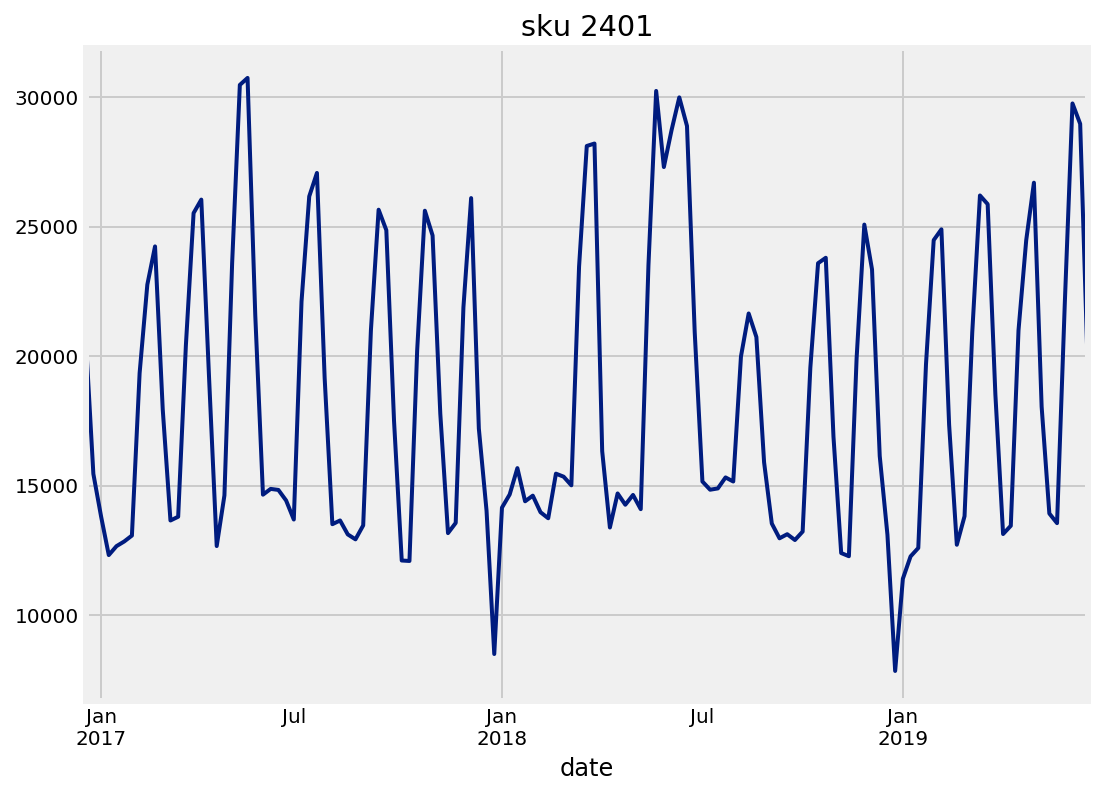

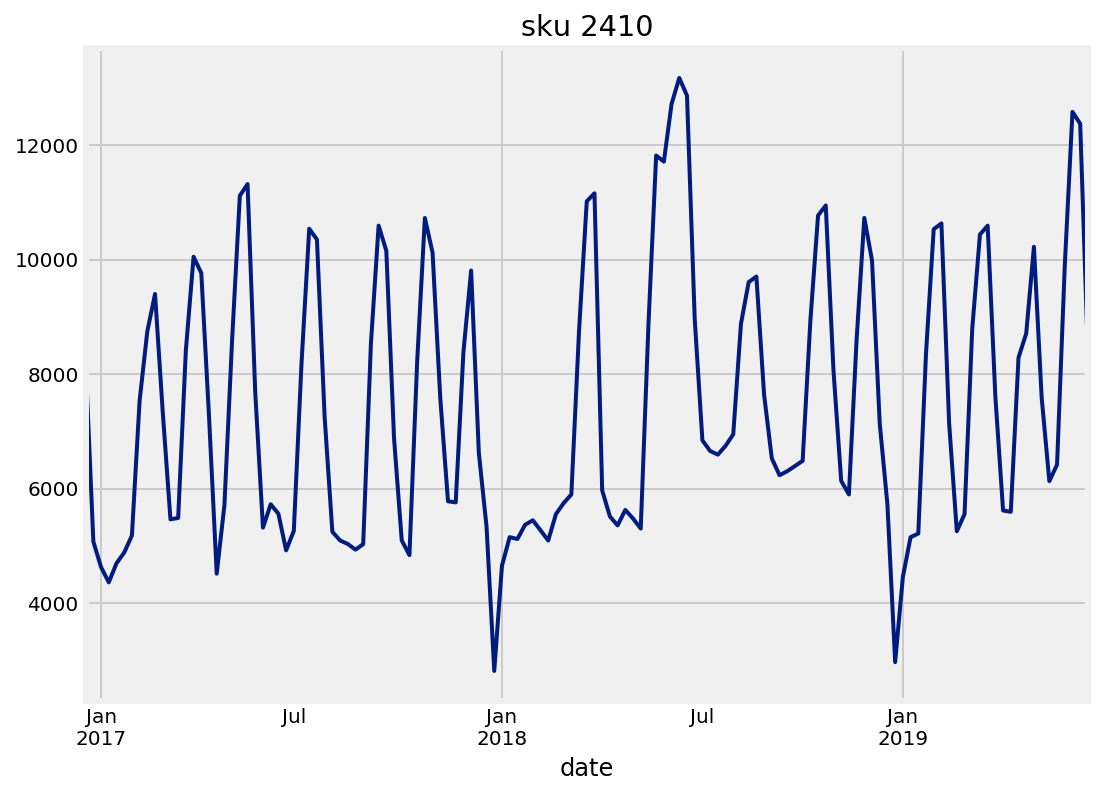

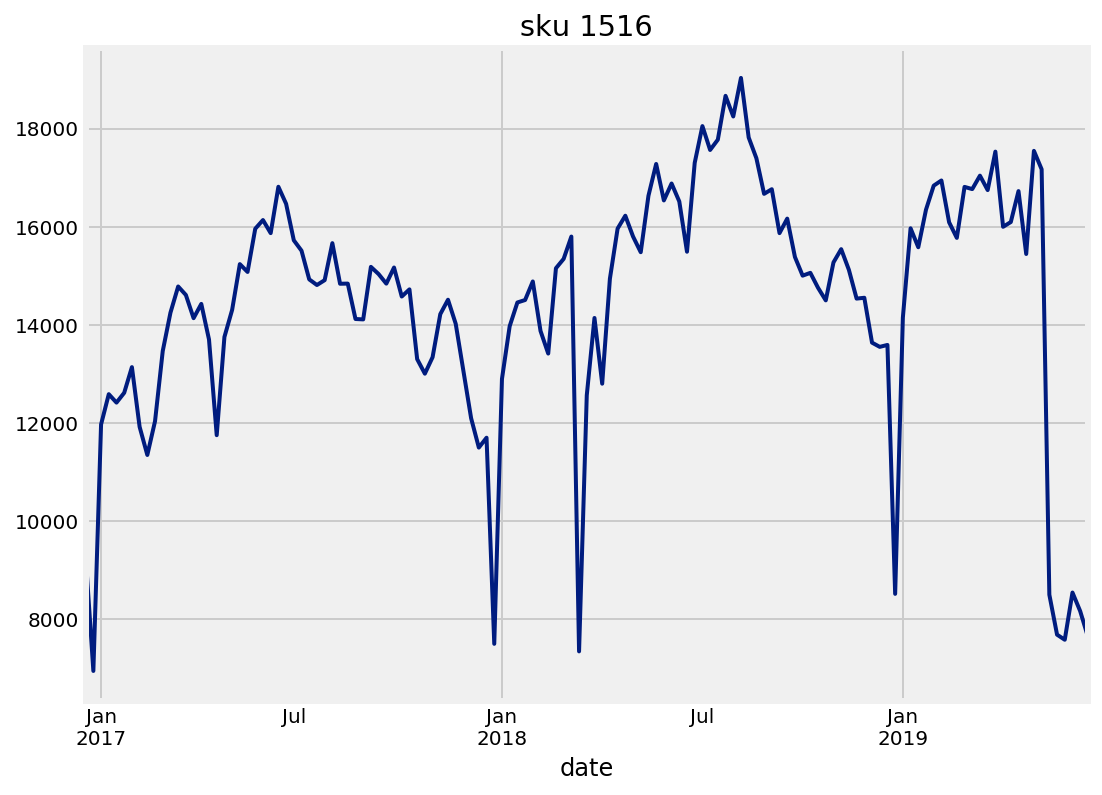

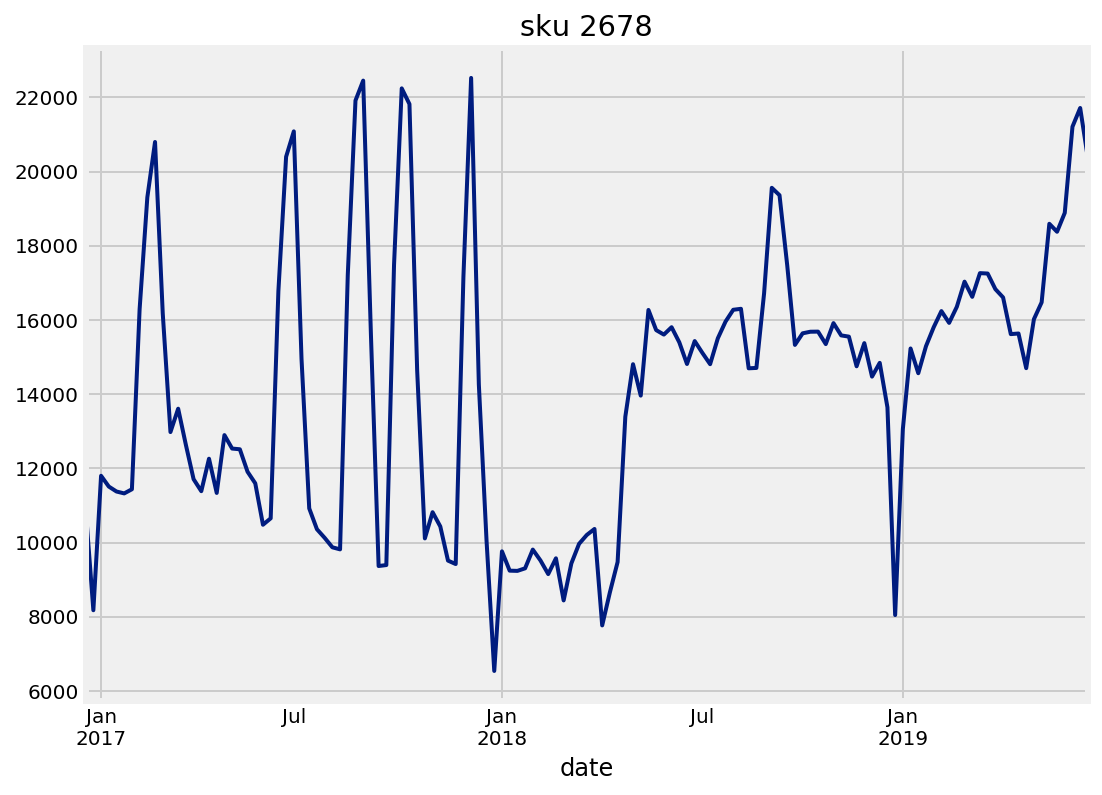

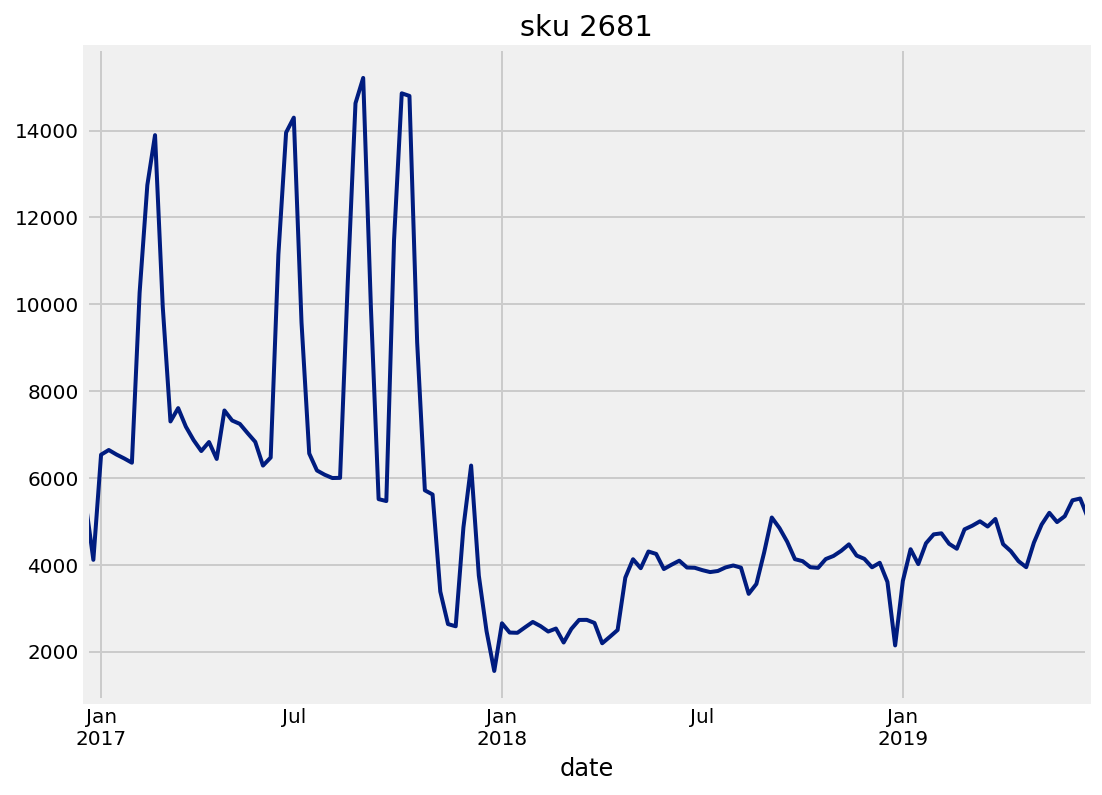

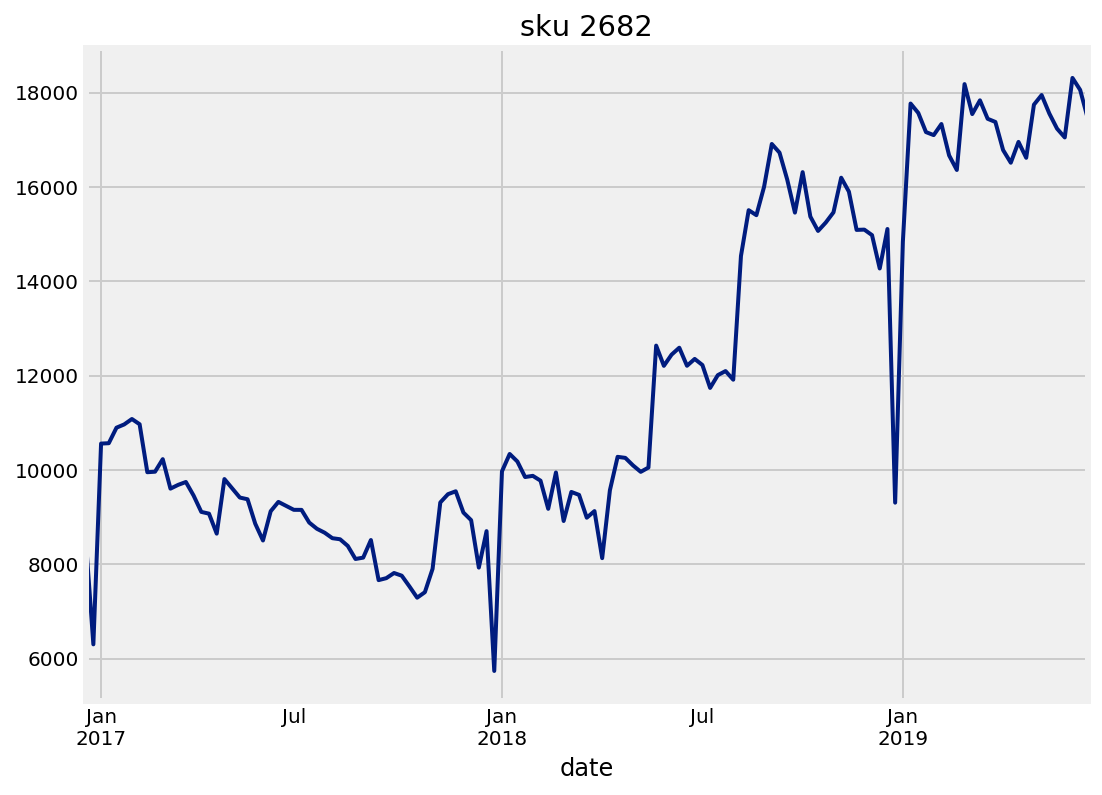

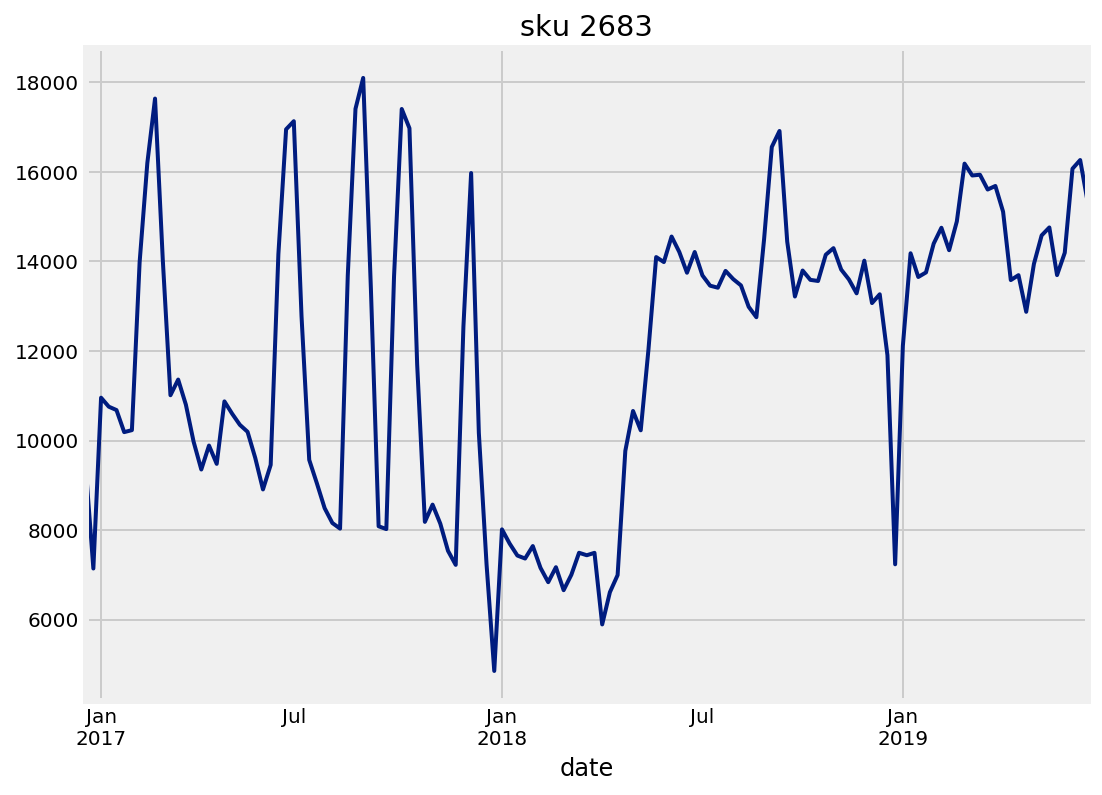

In [94]:
# Visualizzo il target di ogni sku
for sku_id in sku_unique:
    train_df.loc[train_df["sku"]==sku_id].target.plot(figsize=(8,6))
    plt.title("sku {}".format(sku_id))
    plt.show()

In [ ]:
sku_autocorr_list = []
for sku_id in sku_unique:
    correl_target = train_df.loc[train_df["sku"]==sku_id]["target"].autocorr()
    correl_diff1 = train_df.loc[train_df["sku"]==sku_id]["diff1"].autocorr()
    sku_autocorr_list.append((sku_id, "%.2f" % correl_target, "%.2f" % correl_diff1))
print(sku_autocorr_list)

## TARGET e DIFF1

In [ ]:
for sku_id in sku_train:
    plt.plot(train_df.loc[train_df["sku"]==sku_id]["target"], label="target");
    plt.plot(train_df.loc[train_df["sku"]==sku_id]["diff1"], label="diff1");
    plt.legend()
    plt.title(sku_id)
    plt.show()

In [ ]:
for sku_id in sku_train:
    plot_acf(train_df.loc[train_df["sku"]==sku_id]["target"],lags=20)
    plt.title("{} Autocorr {}".format(sku_id, "target"))
plt.show()

In [ ]:
for sku_id in sku_train:
    plot_acf(train_df.loc[train_df["sku"]==sku_id]["diff1"],lags=20)
    plt.title("{} Autocorr {}".format(sku_id, "diff1"))
plt.show()

In [ ]:
#pd.plotting.scatter_matrix(train_df, alpha = 0.2, figsize = (10, 10),diagonal = 'kde')

### SARIMAX: ora creo modello sarimax e tento di predire singolo sku

In [ ]:
from statsmodels.tsa.stattools import adfuller

for sku_id in sku_unique:
    adf_t = adfuller(train_df.loc[train_df["sku"]==sku_id]["target"])
    adf_d = adfuller(train_df.loc[train_df["sku"]==sku_id]["diff1"])
    print("{}".format(sku_id))
    print("p-value of : target: {0:.5f}".format( adf_t[1]))
    print("p-value of : diff1 {0:.5f}".format(adf_d[1]))

# target è random walk, mentre diff1 no, è un white noise?

In [ ]:
#ARMA MODEL
# simulates an AR(1) model, the zero refers to the MA model (see next)
from statsmodels.tsa.arima_model import ARMA
#ARMA PROCESS
from statsmodels.tsa.arima_process import ArmaProcess
np.random.seed(0)

In [ ]:
# creo processo arma(1,0)
ar1 = ArmaProcess(np.array([1, -0.8]), np.array([1]))
# genero 1000 sample
simulated_ar1 = ar1.generate_sample(1000)

plt.figure(figsize=(12,6))
plt.plot(simulated_ar1)
plt.title('AR(1) model with $\phi$ = +0.8')

In [ ]:

model = ARMA(simulated_ar1, order=(1,0))
result = model.fit()

print(result.summary())
print("μ=%.3f ϕ=%.3f"%(result.params[0],result.params[1]))
result.plot_predict(start=900, end=1010)
plt.show()

In [ ]:
# genero modello ARMA(1,0) su cui fitto target di sku-2712
target_model = ARMA(train_df.loc[train_df["sku"]==2712]["target"], order=(1,0))
target_result = target_model.fit()
target_result.plot_predict(start="2016-12-24", end ="2019-04-20")
plt.show()

In [ ]:
# creo processo arma(1,1)
# primo elemento è u, la media, secondo è il coefficiente di a(-1)
# primo elemento è coefficiente di e(t), secondo è il coefficiente di e(t-1)

ar1 = ArmaProcess(np.array([1, -0.8]), np.array([1, 0.5]))
# genero 1000 sample
simulated_ar1 = ar1.generate_sample(1000)

plt.figure(figsize=(8,6))
plt.plot(simulated_ar1)
plt.title('AR(1) model with $\phi$ = +0.8')

In [ ]:
# simulate an MA(1) with theta of 0.5

# no AR component
ar1 = np.array([1])

# MA of order 1 with theta of 0.5
ma1 = np.array([1, 0.5])

# Generate and plot the data
ma1 = ArmaProcess(ar1, ma1)
simulated_ma1 = ma1.generate_sample(nsample=1000)


# Create a MA(1)
ma1_model = ARMA(simulated_ma1, order=(0,1))

# fit the model
ma1_result = ma1_model.fit()

# print the parameters
print(ma1_result.summary())

ma1_result.plot_predict(start=900, end=1010)

print("μ=%.3f θ=%.3f"%(ma1_result.params[0], ma1_result.params[1]))



In [ ]:
# creo arma(3,2) con una serie in input
microsoft_model = ARMA(simulated_ma1, order=(3,2))
#ottengo risultato del modello fittando
microsoft_result = microsoft_model.fit()

print(microsoft_result.summary())
print("μ=%.3f, ϕ1=%.3f, θ1=%.3f"%(microsoft_result.params[0],microsoft_result.params[1],microsoft_result.params[2]))
#predico serie con il modello fittato
microsoft_result.plot_predict()
plt.show()

In [ ]:
 
# Generate and plot the data
ma1 = ArmaProcess(np.array([1]), np.array([1, 0.5]))
simulated_ma1 = ma1.generate_sample(nsample=1000)

ar1 = ArmaProcess(np.array([1, -0.8]), np.array([1]))
simulated_ar1 = ar1.generate_sample(nsample=1000)

arma11 = ArmaProcess(np.array([1, -0.3]), np.array([1, 0.5]))
simulated_arma11 = arma11.generate_sample(nsample=1000)

arma22 = ArmaProcess(np.array([1, -0.8, -0.5, 0.5]), np.array([1, 0.5, 0.5]))
simulated_arma22 = arma22.generate_sample(nsample=1000)

In [ ]:
fig, ax = plt.subplots(4,2,figsize=(16,12))

ax = plt.subplot(4,2,1)
plot_acf(simulated_ma1, alpha=.05, lags=15, ax=ax)
plt.title("arma(0,1) acf")

ax = plt.subplot(4,2,2)
plot_pacf(simulated_ma1, alpha=.05, lags=15, ax=ax)
plt.title("arma(0,1) pacf")


#-----

ax = plt.subplot(4,2,3)
plot_acf(simulated_ar1, alpha=.05, lags=15, ax=ax)
plt.title("arma(1,0) acf")

ax = plt.subplot(4,2,4)
plot_pacf(simulated_ar1, alpha=.05, lags=15, ax=ax)
plt.title("arma(1,0) pacf")


#-----

ax = plt.subplot(4,2,5)
plot_acf(simulated_arma11, alpha=.05, lags=15, ax=ax)
plt.title("arma(1,1) acf")

ax = plt.subplot(4,2,6)
plot_pacf(simulated_arma11, alpha=.05, lags=15, ax=ax)
plt.title("arma(1,1) pacf")

#-----

ax = plt.subplot(4,2,7)
plot_acf(simulated_arma22, alpha=.05, lags=15, ax=ax)
plt.title("arma(2,2) acf")

ax = plt.subplot(4,2,8)
plot_pacf(simulated_arma22, alpha=.05, lags=15, ax=ax)
plt.title("arma(2,2) pacf")

plt.show()

In [ ]:
arma43 = ArmaProcess(np.array([1, -0.8, -0.5, 0.5, 0.3]), np.array([1, 0.5, 0.4, 0.2]))
simulated_arma43 = arma22.generate_sample(nsample=1000)

In [ ]:
sku_id = sku_unique[10]
series = train_df.loc[train_df["sku"]==sku_id]["target"]

plot_pacf(series, alpha=.05, lags=15)
print(sku_id)

In [ ]:
max_model_order = 6
BIC = np.zeros(max_model_order)
for ar_order in range(max_model_order):
    model = ARMA(series, order=(ar_order,0))
    result = model.fit()
    BIC[ar_order] = result.bic
    
plt.plot(range(1,max_model_order), BIC[1:max_model_order], marker='o')
plt.xlabel('Order of AR Model');
plt.ylabel('Bayesian Information Criterion');

In [ ]:
max_model_order = 6
BIC = np.zeros(max_model_order)
for ma_order in range(max_model_order):
    model = ARMA(series, order=(0, ma_order))
    result = model.fit()
    BIC[ma_order] = result.bic
    
plt.plot(range(1,max_model_order), BIC[1:max_model_order], marker='o')
plt.xlabel('Order of MA Model');
plt.ylabel('Bayesian Information Criterion');

In [ ]:
model = ARMA(series, order=(1, 3))
result = model.fit()
result.plot_predict()
plt.show()
result.summary()

In [ ]:
exog_series = train_df.loc[train_df["sku"]==sku_id]["price"].shift(1).fillna(0)
model = ARMA(series, order=(1, 3), exog = exog_series)
result = model.fit()
result.plot_predict()
# rende la series predizione, da confrontare con la seires vera per l'errore
prediction = result.predict()
plt.show()
result.summary()

In [ ]:
adf = adfuller(train_df.loc[train_df["sku"]==sku_id]["target"].diff(1).dropna())
adf[1]

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima_model = SARIMAX(series[:"2018"],order=(1,1,1))
sarima_result = sarima_model.fit()
sarima_result.summary()

In [ ]:
sarima_prediction = sarima_result.get_prediction()
sarima_mean_prediction = sarima_result.predicted_mean
confidence_intervals = sarima_result.conf_int()
lower_limits = confidence_intervals['lower Close']
upper_limits = confidence_intervals['upper Close']

In [ ]:
#DIVISIONE TRAIN VALIDATION TEST

X_train, y_train = create_features(train_df, label='target')

X_train, X_test, y_train ,y_test = split_date(X_train,y_train, "2019-03-15")

y_train = y_train[pd.notnull(X_train).all(1)]
X_train = X_train.dropna()

dev_X, val_X, dev_y, val_y = split_date(X_train, y_train, "2018-09-01")


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
decomposition_multiplicative = seasonal_decompose(train_df['target'], model='multiplicative', extrapolate_trend='freq')